#**Avance 1. Análisis Exploratorio de Datos**

###**Maestría en Inteligencia Artificial Aplicada**
###**Curso: Administración del Desarrollo de Software**
###**Tecnológico de Monterrey**
###**Prof. Mtro. Gilberto Carlo Grajales Aranao**

###**Equipo 1**

####**A01795313 – Karla Alejandra Fonseca Márquez**
####**A01795315 – Julia Gabriela Pinedo**
####**A01795838 – Javier Augusto Rebull Saucedo**
####**A00439670 – Ignacio Sáyago Vela**

**INTRODUCCIÓN**


En este documento se lleva a cabo el análisis exploratorio de datos para la funcionalidad del sistema por desarollar, el cual consiste en estimador inteligente diseñado para predecir la probabilidad de aprobación de visas de trabajo en Estados Unidos.

Para ello se utilizará un conjunto de datos, que contiene 25480 registros de aplicaciones para visa de trabajo en Estados Unidos, con diferentes atributos tanto del empleado como del empleador.

Esta base de datos es abierta y se puede obtener por medio de la siguiente liga en la página de Kaggle https://www.kaggle.com/datasets/moro23/easyvisa-dataset/data

**IMPORTACIÓN DE LIBRERÍAS**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score

from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

from tabulate import tabulate

from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek

from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectFromModel

#**PARTE 1: Análisis descriptivo y preprocesamiento de los datos:**


##**1) El problema de solictudes de aplicación para Visa de Trabajo en los Estados Unidos**

La solicitu de aplicación para Visa de Trabajo en los Estados Unidos es un proceso que puede ser complejo y generar incertidumbre. Es por ello que se intentará establecer un modelo que pueda encontrar patrones entre los datos disponibles, con el fin de predecir la probabilidad de aprobación de visas para los solicitantes.

El dataset que se empleará, contiene 14 atributos que se describen a continuación (EasyVisa_Dataset, 2022):
<br><br>

Att. No.  |Attribute               |Description
---------|-------------------------|-----------------------------------------
1        |case_id:                 |ID of each visa application
2        |continent:               |Information of continent the employee
3|education_of_employee:| Information of education of the employee
4|has_job_experience:| Does the employee has any job experience? Y= Yes; N = No
5|requires_job_training:| Does the employee require any job training? Y = Yes; N = No
6|no_of_employees:| Number of employees in the employer's company
7|yr_of_estab:| Year in which the employer's company was established
8|region_of_employment:| Information of foreign worker's intended region of employment in the US.
9|prevailing_wage:| Average wage paid to similarly employed workers in a specific occupation in the area of intended employment.<br>The purpose of the prevailing wage is to ensure that the foreign worker is not underpaid compared to other workers<br> offering the same or similar service in the same area of employment.
10|unit_of_wage: |Unit of prevailing wage. Values include Hourly, Weekly, Monthly, and Yearly.
11|full_time_position:| Is the position of work full-time? Y = Full Time Position; N = Part Time Position
12|case_status:| Flag indicating if the Visa was certified or denied
<br><br>

Bibliografía:
<br><br>
EasyVisa_Dataset. (2022, April 14). Kaggle. https://www.kaggle.com/datasets/moro23/easyvisa-dataset/data


##**2) Carga de la base de datos**

In [2]:
# Se importa el dataset directamente desde el repositorio de Kaggle

import kagglehub
dataset_path = kagglehub.dataset_download('moro23/easyvisa-dataset')

print('Se ha completado la importación')

100%|██████████| 391k/391k [00:00<00:00, 61.6MB/s]

Extracting files...
Se ha completado la importación


In [13]:
# Se tiene que ejecutar nuevamente descarga

dataset_path = kagglehub.dataset_download('moro23/easyvisa-dataset')

###**Creamos una copia del dataset completo para trabajar en él**##

In [22]:
import shutil
import os

input_path = '/kaggle/input/easyvisa-dataset'
working_path = '/content/kaggle_dataset'

# Copia completa del dataset
shutil.copytree(input_path, working_path, dirs_exist_ok=True)

'/content/kaggle_dataset'

In [23]:
# Cargamos el archivo en un dataframe

df = pd.read_csv('/content/kaggle_dataset/EasyVisa.csv')

In [24]:
# Se visualiza el dataset

pd.set_option('display.max_columns', None)
df

,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,EZYV01,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied
1,EZYV02,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified
2,EZYV03,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied
3,EZYV04,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied
4,EZYV05,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified
...,...,...,...,...,...,...,...,...,...,...,...,...
25475,EZYV25476,Asia,Bachelor's,Y,Y,2601,2008,South,77092.5700,Year,Y,Certified
25476,EZYV25477,Asia,High School,Y,N,3274,2006,Northeast,279174.7900,Year,Y,Certified
25477,EZYV25478,Asia,Master's,Y,N,1121,1910,South,146298.8500,Year,N,Certified
25478,EZYV25479,Asia,Master's,Y,Y,1918,1887,West,86154.7700,Year,Y,Certified


In [25]:
# Se visualiza cuántos valores no nulos contiene cada columna

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25480 entries, 0 to 25479
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   case_id                25480 non-null  object 
 1   continent              25480 non-null  object 
 2   education_of_employee  25480 non-null  object 
 3   has_job_experience     25480 non-null  object 
 4   requires_job_training  25480 non-null  object 
 5   no_of_employees        25480 non-null  int64  
 6   yr_of_estab            25480 non-null  int64  
 7   region_of_employment   25480 non-null  object 
 8   prevailing_wage        25480 non-null  float64
 9   unit_of_wage           25480 non-null  object 
 10  full_time_position     25480 non-null  object 
 11  case_status            25480 non-null  object 
dtypes: float64(1), int64(2), object(9)
memory usage: 2.3+ MB


No existen valores nulos en el conjunto de datos

In [26]:
# Se obtiene el tipo de dato de cada columna

df.dtypes

,0
case_id,object
continent,object
education_of_employee,object
has_job_experience,object
requires_job_training,object
no_of_employees,int64
yr_of_estab,int64
region_of_employment,object
prevailing_wage,float64
unit_of_wage,object


El conjunto contiene solamente dos variables numéricas de tipo entero (no_of_employees y yr_of_estab) y una variable numérica de tipo flotante (prevailing_wage). Todas las demás variables son categóricas.

##**Variables Numéricas**##

In [27]:
# Se obtiene el resumen estadístico de los datos numéricos

df.describe().T

,count,mean,std,min,25%,50%,75%,max
no_of_employees,25480.0,5667.043210,22877.928848,-26.0000,1022.00,2109.00,3504.0000,602069.00
yr_of_estab,25480.0,1979.409929,42.366929,1800.0000,1976.00,1997.00,2005.0000,2016.00
prevailing_wage,25480.0,74455.814592,52815.942327,2.1367,34015.48,70308.21,107735.5125,319210.27


Se observan dos detalles importantes. La variable num_of_employees tiene valores negativos y la variable prevailing_wage tiene un mínimo de 2.1367. Esto se debe a que el salario está por hora, semana, mes o año. Se debe ver la forma de uniformizar el salario para ponerlo todo en año con el fin de poder utilizar esta variable.

In [28]:
# Verificamos cuantos registros negativos tiene la variable no_of_employees

df.loc[df['no_of_employees']<0].shape[0]

33

Son pocos registros con valores negativos, por lo que se convertirán a valores positivos para que los datos no sean incongruentes

In [29]:
# Se toma el valor absoluto de la variable no_of_employees

df['no_of_employees']=abs(df['no_of_employees'])

In [30]:
# Se comprueba que ya no existan valores negativos

df.loc[df['no_of_employees']<0].shape[0]

0

Para uniformizar el salario a anual, haremos la prueba considerando 2000 horas al año, 52 semanas por año, y 12 meses por año. Primero crearemos datasets de apoyo para hacer estas conversiones y comparar los resultados

In [31]:
# Creamos copias del dataframe con base en los diferentes valores de 'unit_of_wage'
df_year = df[df['unit_of_wage'] == 'Year'].copy()
df_month = df[df['unit_of_wage'] == 'Month'].copy()
df_week = df[df['unit_of_wage'] == 'Week'].copy()
df_hour = df[df['unit_of_wage'] == 'Hour'].copy()

# Mostramos el tamaño de los dataframes
print(f"Shape of df_year: {df_year.shape}")
print(f"Shape of df_month: {df_month.shape}")
print(f"Shape of df_week: {df_week.shape}")
print(f"Shape of df_hour: {df_hour.shape}")

Shape of df_year: (22962, 12)
Shape of df_month: (89, 12)
Shape of df_week: (272, 12)
Shape of df_hour: (2157, 12)


In [32]:
# Comparamos el resumen estadístico para los diferentes dataframes
display("---------Year--------")
display(df_year.describe().T)
display("---------Month--------")
display(df_month.describe().T)
display("---------Week--------")
display(df_week.describe().T)
display("---------Hour--------")
display(df_hour.describe().T)

'---------Year--------'

,count,mean,std,min,25%,50%,75%,max
no_of_employees,22962.0,5803.277458,23487.021458,11.0,1037.000,2146.0,3566.50,602069.00
yr_of_estab,22962.0,1980.042026,41.913560,1800.0,1977.000,1997.0,2005.00,2016.00
prevailing_wage,22962.0,81228.077133,49951.473223,100.0,43715.955,76174.5,111341.96,319210.27


'---------Month--------'

,count,mean,std,min,25%,50%,75%,max
no_of_employees,89.0,2759.595506,4529.557952,46.00,879.00,2101.00,3014.0,36511.00
yr_of_estab,89.0,1973.516854,48.427808,1819.00,1967.00,1995.00,2004.0,2013.00
prevailing_wage,89.0,87592.864045,59525.124924,1599.28,44986.24,81826.01,121629.6,264362.95


'---------Week--------'

,count,mean,std,min,25%,50%,75%,max
no_of_employees,272.0,6582.580882,26231.867394,64.00,1019.0000,1950.00,3338.25,278152.00
yr_of_estab,272.0,1971.323529,45.234181,1807.00,1959.7500,1991.50,2002.00,2016.00
prevailing_wage,272.0,85606.820515,44802.704810,2183.23,51408.2775,85075.82,111331.91,280175.95


'---------Hour--------'

,count,mean,std,min,25%,50%,75%,max
no_of_employees,2157.0,4221.840519,14847.408417,14.0000,877.0000,1836.0000,2974.0000,288512.0000
yr_of_estab,2157.0,1973.943904,45.896877,1807.0000,1968.0000,1993.0000,2003.0000,2016.0000
prevailing_wage,2157.0,414.570513,275.015000,2.1367,152.7003,372.6523,637.3111,999.9195


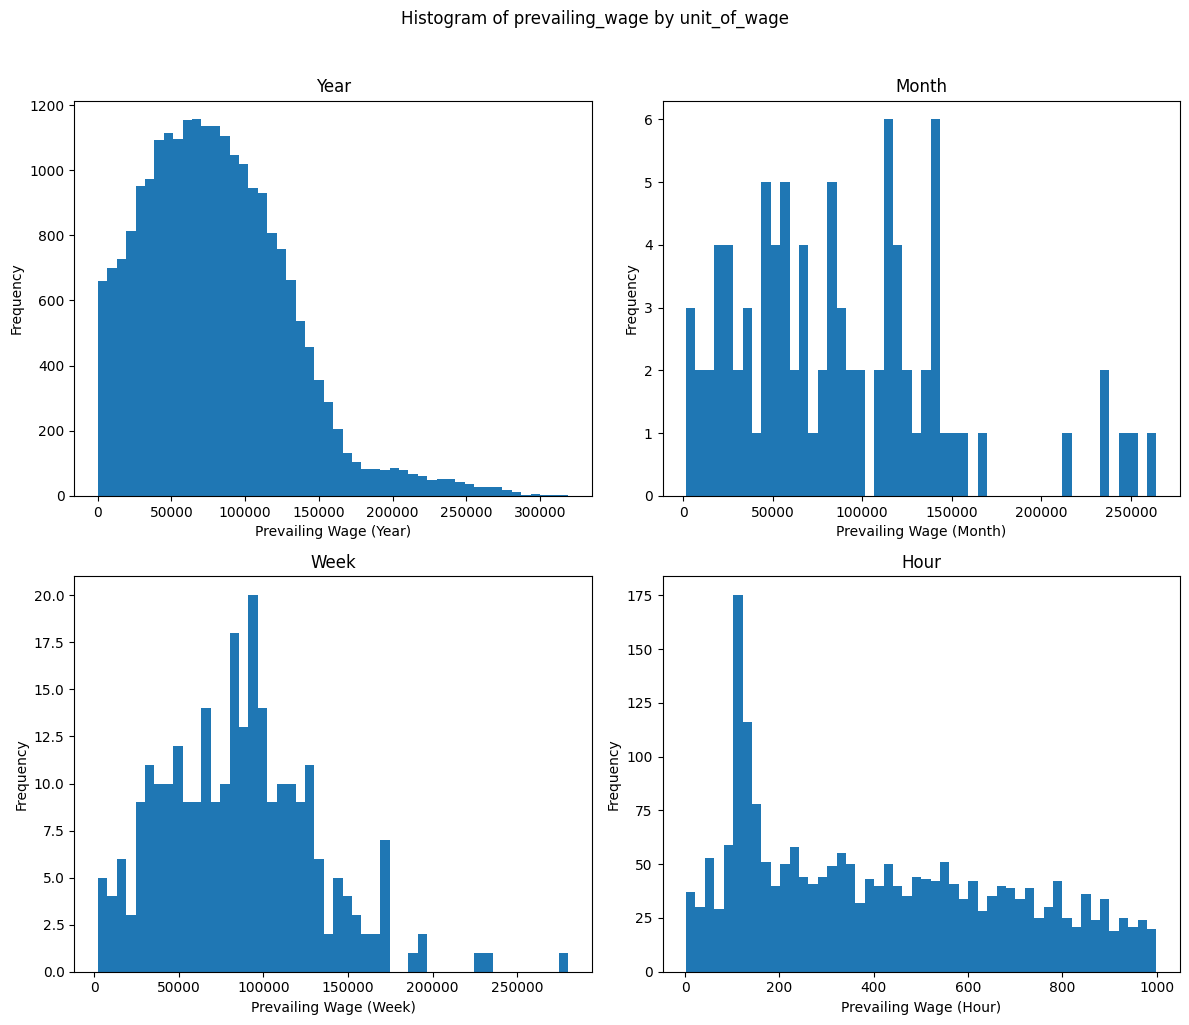

In [33]:
# Generamos histrogramas de los 4 dataframes para ver cómo se distribuye el salario en cada dataframe

import matplotlib.pyplot as plt


fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Histogram of prevailing_wage by unit_of_wage', y=1.02)

axes[0, 0].hist(df_year['prevailing_wage'], bins=50)
axes[0, 0].set_title('Year')
axes[0, 0].set_xlabel('Prevailing Wage (Year)')
axes[0, 0].set_ylabel('Frequency')

axes[0, 1].hist(df_month['prevailing_wage'], bins=50)
axes[0, 1].set_title('Month')
axes[0, 1].set_xlabel('Prevailing Wage (Month)')
axes[0, 1].set_ylabel('Frequency')

axes[1, 0].hist(df_week['prevailing_wage'], bins=50)
axes[1, 0].set_title('Week')
axes[1, 0].set_xlabel('Prevailing Wage (Week)')
axes[1, 0].set_ylabel('Frequency')

axes[1, 1].hist(df_hour['prevailing_wage'], bins=50)
axes[1, 1].set_title('Hour')
axes[1, 1].set_xlabel('Prevailing Wage (Hour)')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


Comose puede ver, cuando el salario se indica por año, mes o semana, los valores máximos son de 250,000 a 300,000 aprox. Sin embargo, cuando el salario se indica por hora, el máximo es 1000 (aprox). Por lo tanto, se multiplicará el salario por hora por un factor de 250 para que el máximo sea 250,000 aprox, con el objeto de ver si posteriormente se puede trabajar esta variable para clasificarla por rangos con el fin de tener una distribución más uniforme

In [34]:
df_hour['prevailing_wage'] = df_hour['prevailing_wage'] * 250

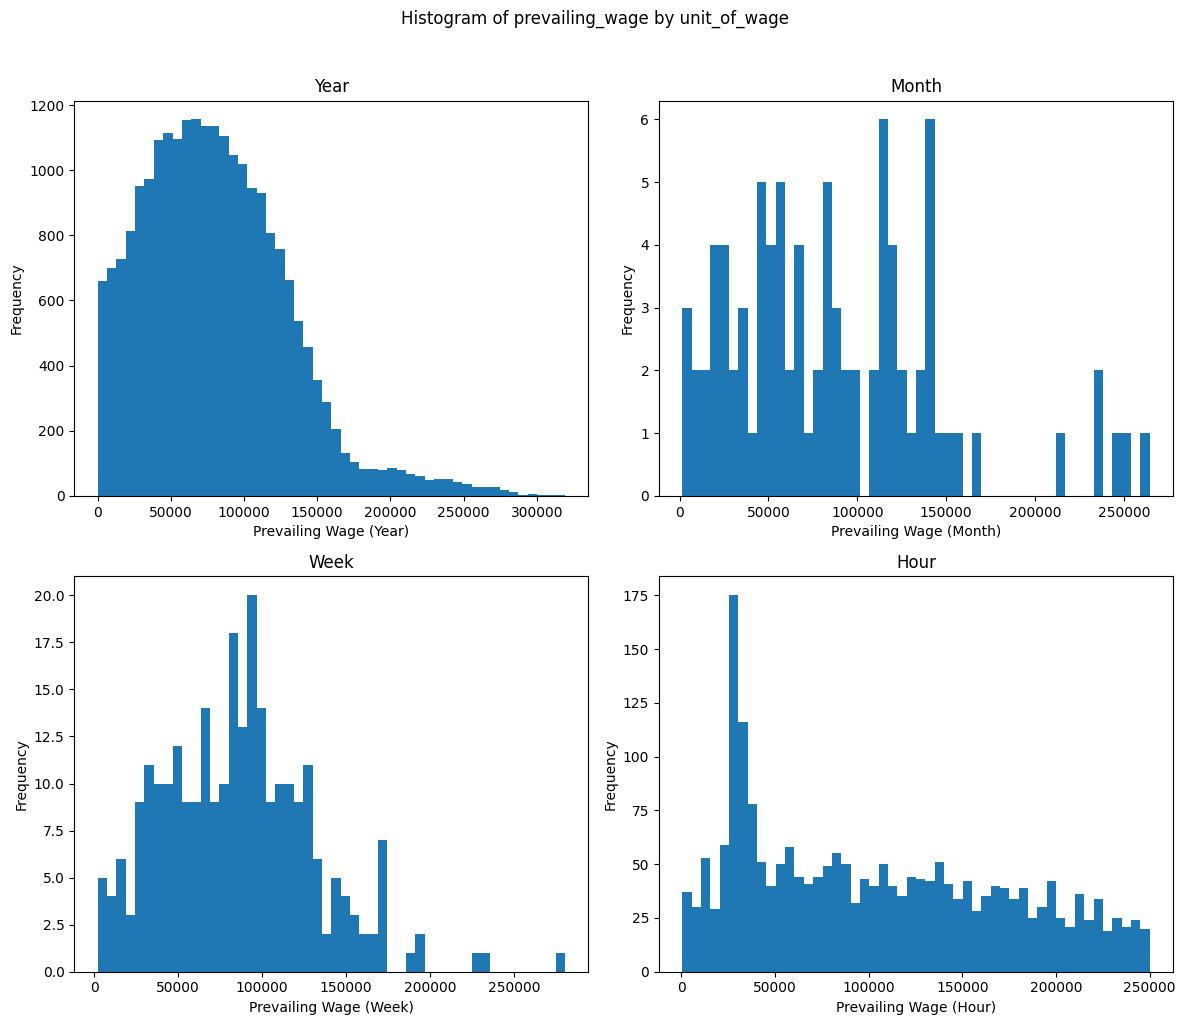

In [35]:
# Generamos histrogramas de los 4 dataframes para ver cómo se distribuye el salario en cada dataframe

import matplotlib.pyplot as plt


fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Histogram of prevailing_wage by unit_of_wage', y=1.02)

axes[0, 0].hist(df_year['prevailing_wage'], bins=50)
axes[0, 0].set_title('Year')
axes[0, 0].set_xlabel('Prevailing Wage (Year)')
axes[0, 0].set_ylabel('Frequency')

axes[0, 1].hist(df_month['prevailing_wage'], bins=50)
axes[0, 1].set_title('Month')
axes[0, 1].set_xlabel('Prevailing Wage (Month)')
axes[0, 1].set_ylabel('Frequency')

axes[1, 0].hist(df_week['prevailing_wage'], bins=50)
axes[1, 0].set_title('Week')
axes[1, 0].set_xlabel('Prevailing Wage (Week)')
axes[1, 0].set_ylabel('Frequency')

axes[1, 1].hist(df_hour['prevailing_wage'], bins=50)
axes[1, 1].set_title('Hour')
axes[1, 1].set_xlabel('Prevailing Wage (Hour)')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


In [36]:
# Insertamos una nueva columna para posteriormente editar el salario

df['adjusted_prevailing_wage'] = df['prevailing_wage']

In [37]:
# Multiplicamos pur un factor de 250 el valor de la columna 'adjusted_prevailing_wage' en los registros donde el salario esté por hora

df.loc[df['unit_of_wage'] == 'Hour', 'adjusted_prevailing_wage'] = df['adjusted_prevailing_wage'] * 250

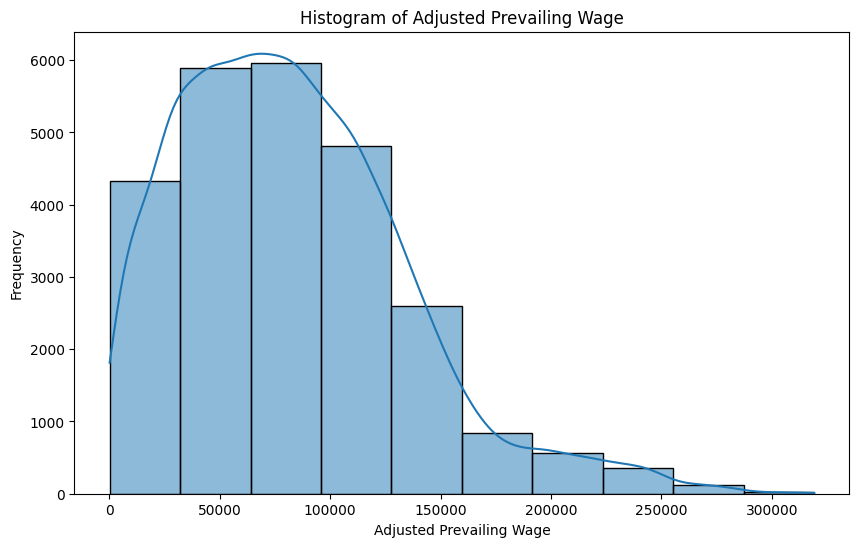

In [38]:
# Revisamos el histrograma de 'adjusted_prevailing_wage' después del cambio

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sns.histplot(df['adjusted_prevailing_wage'], bins=10, kde=True)
plt.title('Histogram of Adjusted Prevailing Wage')
plt.xlabel('Adjusted Prevailing Wage')
plt.ylabel('Frequency')
plt.show()

<ipython-input-39-eeef1b2a398c>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='wage_range', order=labels, palette='viridis')


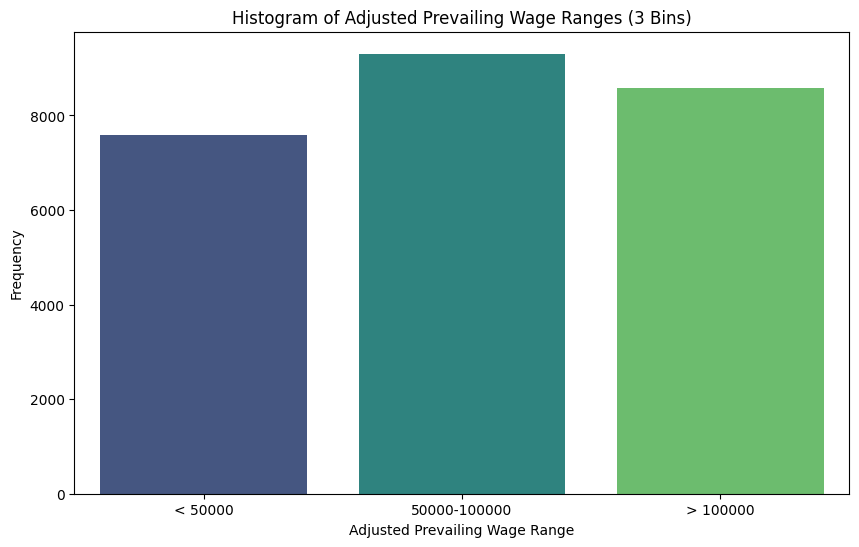

In [39]:
# Ajustamos el histograma para que muestre solamente 3 rangos de valores, para ver si obtenemos una ditribución más uniforme

import pandas as pd
import matplotlib.pyplot as plt
# Define the bin edges
bins = [0, 50000, 100000, df['adjusted_prevailing_wage'].max() + 1] #al último bin se le suma 1 al máximo para que no quede fuera del bin el registro con el valor máximo
labels = ['< 50000', '50000-100000', '> 100000']

# Create a new column with the wage ranges
df['wage_range'] = pd.cut(df['adjusted_prevailing_wage'], bins=bins, labels=labels, right=False)

# Plot the histogram
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='wage_range', order=labels, palette='viridis')
plt.title('Histogram of Adjusted Prevailing Wage Ranges (3 Bins)')
plt.xlabel('Adjusted Prevailing Wage Range')
plt.ylabel('Frequency')
plt.show()

Se tiene una mejor distribución con este rango. Por lo tanto, se creará una variable categórica llamada 'prevailing_wage_range' y se desechan las columnas 'prevailing_wage' y 'adjusted_prevailing_wage'

In [40]:
# prompt: drop the columns 'adjusted_prevailing_wage', 'prevailing_wage' and 'unit_of_wage' of dataframe 'df'

df = df.drop(['adjusted_prevailing_wage', 'prevailing_wage'], axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25480 entries, 0 to 25479
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   case_id                25480 non-null  object  
 1   continent              25480 non-null  object  
 2   education_of_employee  25480 non-null  object  
 3   has_job_experience     25480 non-null  object  
 4   requires_job_training  25480 non-null  object  
 5   no_of_employees        25480 non-null  int64   
 6   yr_of_estab            25480 non-null  int64   
 7   region_of_employment   25480 non-null  object  
 8   unit_of_wage           25480 non-null  object  
 9   full_time_position     25480 non-null  object  
 10  case_status            25480 non-null  object  
 11  wage_range             25480 non-null  category
dtypes: category(1), int64(2), object(9)
memory usage: 2.2+ MB


In [41]:
# prompt: generate a script to convert the Dtype of column 'wage_range' from 'category' to 'object'

df['wage_range'] = df['wage_range'].astype('object')
df.dtypes

,0
case_id,object
continent,object
education_of_employee,object
has_job_experience,object
requires_job_training,object
no_of_employees,int64
yr_of_estab,int64
region_of_employment,object
unit_of_wage,object
full_time_position,object


In [42]:
# Se hace una lista de variables numéricas
num_cols = df.select_dtypes(include='integer').columns.tolist()
num_cols

['no_of_employees', 'yr_of_estab']

In [43]:
# Se verifica que la variable dependiente sea binaria en todo el conjunto de datos

df['case_status'].nunique()

2

**a) ¿Cuántas y cuáles de las variables son numéricas?**

Con el método .info() podemos ver que el dataframe ahora solamente tiene 2 variables numéricas de tipo entero.
<br><br>
**i. ¿Cuántas y cuáles de estas variables numéricas son de valor entero?**

En este dataframe, las 2 variables numéricas que existen son de valor entero. El listado de estas variables obtenido con la instrucción: `df.select_dtypes(include='integer').columns.tolist()`, es el siguiente:

['no_of_employees', 'yr_of_estab']


<br><br>

**ii. ¿Cuántas y cuáles de estas variables numéricas son de valor real (flotante)?**

Con el método info() podemos ver que este dataframe después de quitar la variable 'prevailing_wage' ya no contiene variables numéricas de valor real, sólo enteros, objetos (texto) y una clase.
<br><br>

**iii. De existir el caso, ¿cuántas y cuáles de estas variables numéricas se pueden anular del problema?**

Aún es muy pronto para descartar cualquiera de las dos variables numéricas que quedan. Más adelante veremos si aportan o no información relevante para el desarrollo del modelo.

##**Variables Categóricas**##

In [44]:
# Se hace una lista de variables categóricas
txt_cols = df.select_dtypes(include='object').columns.tolist()
txt_cols

['case_id',
 'continent',
 'education_of_employee',
 'has_job_experience',
 'requires_job_training',
 'region_of_employment',
 'unit_of_wage',
 'full_time_position',
 'case_status',
 'wage_range']

In [45]:
df.describe(include = 'object').T.rename(columns = {'count':'Recuento', 'unique':'Cardinalidad', 'top':'Moda', 'freq':'Frecuencia'})

,Recuento,Cardinalidad,Moda,Frecuencia
case_id,25480,25480,EZYV25480,1
continent,25480,6,Asia,16861
education_of_employee,25480,4,Bachelor's,10234
has_job_experience,25480,2,Y,14802
requires_job_training,25480,2,N,22525
region_of_employment,25480,5,Northeast,7195
unit_of_wage,25480,4,Year,22962
full_time_position,25480,2,Y,22773
case_status,25480,2,Certified,17018
wage_range,25480,3,50000-100000,9304


**b) ¿Cuántas y cuáles de las variables son categóricas?**

Con la instrucción: `df.select_dtypes(include='object').columns.tolist()`, obtenemos el siguiente listado de las 9 variables categóricas que contiene el dataframe:

['case_id',
 'continent',
 'education_of_employee',
 'has_job_experience',
 'requires_job_training',
 'region_of_employment',
 'full_time_position',
 'case_status',
 'wage_range']

Por otra parte, con la instrucción: `df.describe(include = 'object').T.rename(columns = {'count':'Recuento', 'unique':'Cardinalidad', 'top':'Moda', 'freq':'Frecuencia'})`, obtenemos la información requerida para responder las siguientes preguntas:
<br><br>

**i. ¿Cuántas y cuáles de estas variables son binarias?**

Las 4 variables binarias que existen en el dataframe son:

Variable|Tipo
--------|-------
has_job_experience|Binaria
requires_job_training|Binaria
full_time_position|Binaria
case_status|Binaria

<br>


**ii. ¿Cuántas y cuáles de estas variables son nominales? Indica el total de niveles que tiene cada una de estas variables.**

Las 2 variables nominales son:

Variable|Tipo|Número de niveles
--------|----|------------------
continent|Nominal|6
region_of_employment|Nominal|5

<br><br>

**iii. ¿Cuántas y cuáles de estas variables son ordinales? Indica el total de niveles que tiene cada una de estas variables.**

Las 2 variables ordinales son:

Variable|Tipo|Número de niveles
--------|----|------------------
case_id|Ordinal|25480
education_of_employee|Ordinal|4
wage_range|Ordinal|3

<br><br>

**iv. De existir el caso, ¿cuántas y cuáles de estas variables categóricas se pueden anular del problema?**

<Mark>La variable **'case_id'** se puede anular</Mark> puesto que al ser un código identificador diferente para cada registro no aporta información para el desarrollo del modelo



**c) En esta base de datos y con base a la información dada, ¿existe alguna o algunas variables cuya clasificación en algún tipo de dato dependa del analista? ¿Cuáles y por qué?**

Solamente la variable 'prevailing_wage' que como vimos, su valor estaba en función de 'unit_of_wage' y se decidió establecer un rango de salarios en lugar de tomar el valor numérico flotante de la variable, lo cual fue decisión del analista

**d) Se eliminan del problema todas las variables que no están aportando información alguna.**

La varaible: 'case_id' se eliminará permanentemente del dataframe con la instrucción:
<br><br>
df.drop(columns=['case_id'], inplace=True)

In [46]:
df.drop(columns=['case_id'], inplace=True)
df.T

Output hidden; open in https://colab.research.google.com to view.

**3) Se realiza una partición de los datos en Entrenamiento, Validación y Prueba, del 70%, 15% y 15%, respectivamente. Llamando a dichos conjuntos Xtrain, Xval, Xtest, ytrain, yval, ytest, para los datos de entrada y de salida, respectivamente. Dicha partición debe conservar la estratificación de las clases de la variable “case_status”.**

In [47]:
## En la siguiente liga se indica como partir en train, val y test utilizando la función train_test_split (con la cual se puede conservar la estratificación)
## https://datascience.stackexchange.com/questions/15135/train-test-validation-set-splitting-in-sklearn

## Tambien explica como definir el tamaño del conjunto de validación utilizando una segunda vez la función train_test_split
## (1.0/(1.0-test_size))*validation_size = second_test_size
## En este caso: (1.0/(1.0-0.15))*0.15 = 0.17647

# Se divide el dataframe en los conjuntos Auxiliar y Prueba
strat_aux_set, strat_test_set = train_test_split(
df, test_size=0.15, stratify=df["case_status"], random_state=1)

# Se divide el conjunto Auxiliar en los conjuntos Entrenamiento y Validación
strat_train_set, strat_val_set = train_test_split(
strat_aux_set, test_size=0.17647, stratify=strat_aux_set["case_status"], random_state=1)

# Se subdividen los conjuntos de Entrenamiento, Validación y Prueba en datos de Entrada y de Salida
Xtrain = strat_train_set.drop('case_status', axis='columns')
Xval = strat_val_set.drop('case_status', axis='columns')
Xtest = strat_test_set.drop('case_status', axis='columns')
ytrain = strat_train_set['case_status']
yval = strat_val_set['case_status']
ytest = strat_test_set['case_status']

# Se covierten los datos de salida en dataframes
ytrain = ytrain.to_frame()
yval = yval.to_frame()
ytest = ytest.to_frame()

#se eliminan las variables auxiliares
del strat_train_set
del strat_val_set
del strat_test_set
del strat_aux_set

In [48]:
display(Xtrain,Xval,Xtest,ytrain,yval,ytest)

,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,unit_of_wage,full_time_position,wage_range
9036,Africa,Bachelor's,N,N,1070,1995,Northeast,Hour,Y,> 100000
21818,Asia,Bachelor's,N,N,2197,2000,Northeast,Year,Y,< 50000
18343,Europe,Doctorate,Y,Y,2511,2012,West,Year,Y,> 100000
12820,Asia,Bachelor's,N,Y,835,2009,West,Year,Y,50000-100000
21719,Asia,Bachelor's,Y,N,3936,2008,South,Year,Y,50000-100000
...,...,...,...,...,...,...,...,...,...,...
20737,Asia,Bachelor's,Y,N,3416,1969,Northeast,Hour,Y,50000-100000
20965,Asia,Master's,N,N,1758,1995,South,Year,Y,50000-100000
2473,Europe,Bachelor's,N,N,1036,1985,West,Hour,Y,> 100000
743,Europe,Bachelor's,Y,Y,1154,2010,South,Year,Y,50000-100000


,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,unit_of_wage,full_time_position,wage_range
18754,Asia,Bachelor's,N,N,803,2014,Northeast,Year,Y,50000-100000
5834,Asia,Doctorate,Y,N,1245,1971,South,Year,Y,> 100000
6962,Europe,Master's,N,N,564,1994,West,Year,Y,50000-100000
19174,Asia,Bachelor's,N,N,4505,2013,Midwest,Year,Y,50000-100000
21977,Asia,Master's,Y,N,1919,1999,Midwest,Year,Y,50000-100000
...,...,...,...,...,...,...,...,...,...,...
710,Europe,Bachelor's,Y,N,1955,2004,West,Year,Y,< 50000
6839,North America,Bachelor's,Y,N,361,2000,Northeast,Year,Y,> 100000
20114,Europe,High School,N,N,209,1999,Midwest,Year,Y,> 100000
6425,Europe,Bachelor's,Y,N,1555,2014,Northeast,Year,Y,< 50000


,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,unit_of_wage,full_time_position,wage_range
755,Asia,High School,Y,N,1911,2001,Northeast,Year,Y,< 50000
22508,Asia,Bachelor's,N,N,2039,2001,South,Year,Y,> 100000
483,North America,Doctorate,Y,N,2691,2014,Northeast,Year,Y,< 50000
1724,Asia,Bachelor's,N,Y,2536,1994,Northeast,Year,Y,< 50000
14084,Asia,Master's,N,N,996,2008,Northeast,Hour,Y,< 50000
...,...,...,...,...,...,...,...,...,...,...
5572,Asia,Master's,Y,N,1721,1998,Northeast,Year,N,50000-100000
767,Asia,Bachelor's,Y,N,1573,2008,West,Year,Y,< 50000
13433,Asia,Master's,Y,N,339,1999,South,Year,Y,50000-100000
15409,Asia,Doctorate,N,Y,1819,2009,West,Year,Y,> 100000


,case_status
9036,Certified
21818,Certified
18343,Certified
12820,Certified
21719,Denied
...,...
20737,Denied
20965,Denied
2473,Certified
743,Certified


,case_status
18754,Denied
5834,Certified
6962,Denied
19174,Certified
21977,Certified
...,...
710,Certified
6839,Certified
20114,Denied
6425,Certified


,case_status
755,Denied
22508,Denied
483,Certified
1724,Denied
14084,Denied
...,...
5572,Certified
767,Certified
13433,Certified
15409,Certified


In [49]:
#Se despliegua 'case_status' como categórica

df['case_status'].astype(object).describe(include = 'object')

,case_status
count,25480
unique,2
top,Certified
freq,17018


In [50]:
#Se verifica el conjunto de entrenamiento
ytest.astype(object).describe(include = 'object')

,case_status
count,3822
unique,2
top,Certified
freq,2553


In [51]:
#Se verifica el conjunto de validación
yval.astype(object).describe(include = 'object')

,case_status
count,3822
unique,2
top,Certified
freq,2553


In [52]:
#Se verifica el conjunto de prueba
ytrain.astype(object).describe(include = 'object')

,case_status
count,17836
unique,2
top,Certified
freq,11912


En los tres conjuntos (entrenamiento, validación y prueba) se mantiene la misma proporción de observaciones con valor "0 " en la variable 'case_status' que en el dataframe, lo cual significa que los conjuntos conservaron la estratificación de esta variable.
<br><br>
Por otra parte, el recuento nos indica que efectivamente la partición de los datos en Entrenamiento, Validación y Prueba, fue del 70%, 15% y 15%, respectivamente.

**a) Se despliega la dimensión obtenida de los tres conjuntos: Entrenamiento, Validación y Prueba.**

In [53]:
print("La dimensión de Xtrain es " + str(Xtrain.shape))
print("La dimensión de Xval es " + str(Xval.shape))
print("La dimensión de Xtest es " + str(Xtest.shape))
print("La dimensión de ytrain es " + str(ytrain.shape))
print("La dimensión de yval es " + str(yval.shape))
print("La dimensión de ytest es " + str(ytest.shape))

La dimensión de Xtrain es (17836, 10)
La dimensión de Xval es (3822, 10)
La dimensión de Xtest es (3822, 10)
La dimensión de ytrain es (17836, 1)
La dimensión de yval es (3822, 1)
La dimensión de ytest es (3822, 1)


##**Transformación de variables numéricas**

**4) Se obtienen los histogramas de las variables
numéricas, usando solamente el conjunto de Entrenamiento**

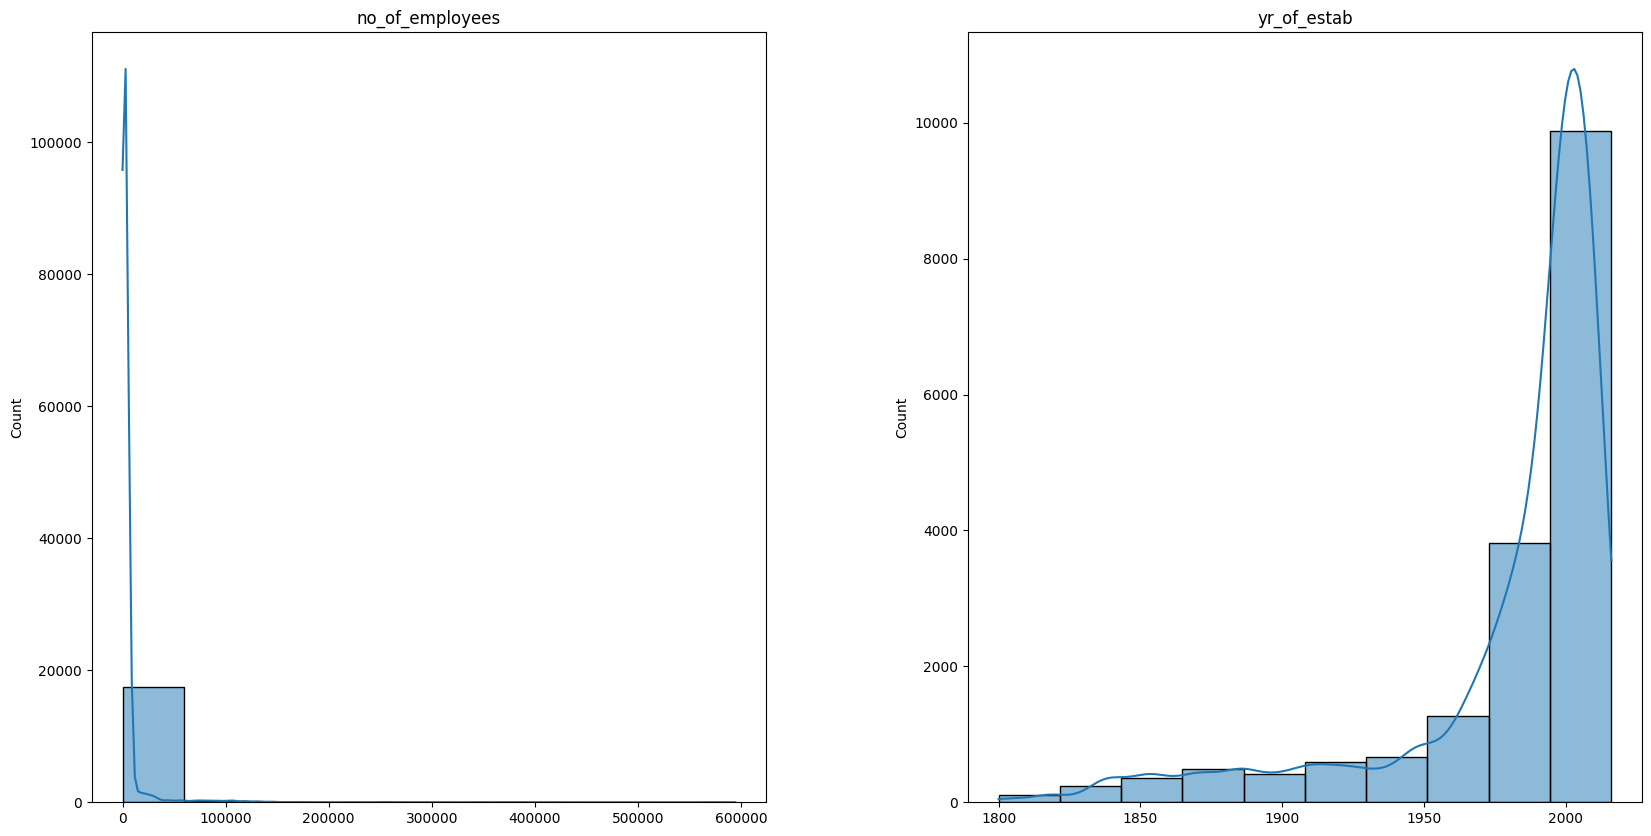

In [54]:
# En este apartado solamente se dará tratamiento a las variables numéricas
# que funcionan como categóricas ordinales.

# Se hace una lista de todas las variables numéricas
num_cols = Xtrain.select_dtypes(include=np.number).columns.tolist()

fig, axes = plt.subplots(1,2, figsize=(20,10)) # ---> Matplotlib
plt.subplots_adjust(wspace=0.3)
axes = axes.ravel()
for col, ax in zip(Xtrain[num_cols], axes):
  sns.histplot(x = Xtrain[col], kde = True, ax=ax, bins=10)
  #sns.countplot(x = Xtrain[col], ax=ax) # En lugar de histograma se podría graficar el conteo si furan variables numéricas con función de categóricas
  ax.set(title=f'{col}', xlabel=None) # ---> Matplotlib
fig.subplots_adjust(hspace=.5)



Debido a que las variables numéricas se encuentran muy sesgadas y es poco probable que aporten información relevante con su valor numérico, se intentará clasificarlas por rangos y convertirlas en categóricas

<ipython-input-55-0a6e9932a410>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='no_of_employees_range', order=labels, palette='viridis')


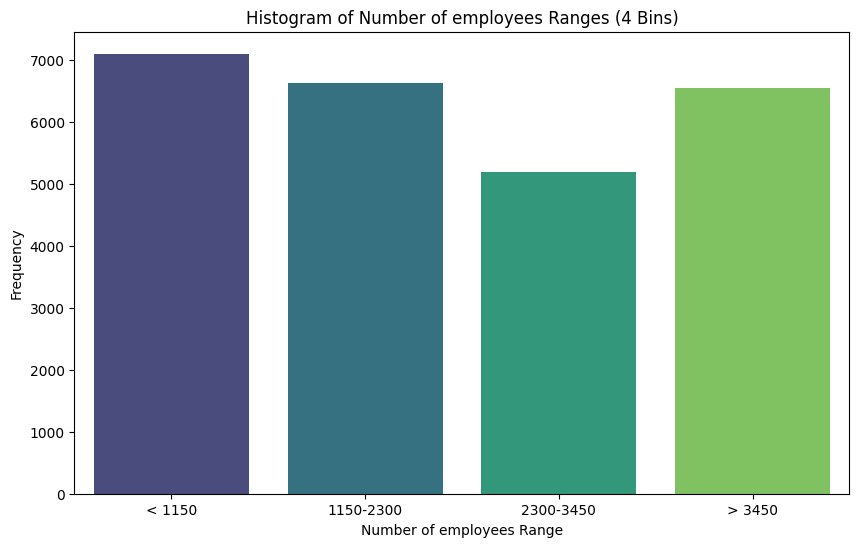

In [55]:
# Dividimos el número de empleados en rangos

# Define the bin edges
bins = [0, 1150, 2300, 3450, df['no_of_employees'].max() + 1] #al último bin se le suma 1 al máximo para que no quede fuera del bin el registro con el valor máximo
labels = ['< 1150', '1150-2300', '2300-3450', '> 3450']

# Create a new column with the wage ranges
df['no_of_employees_range'] = pd.cut(df['no_of_employees'], bins=bins, labels=labels, right=False)

# Plot the histogram
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='no_of_employees_range', order=labels, palette='viridis')
plt.title('Histogram of Number of employees Ranges (4 Bins)')
plt.xlabel('Number of employees Range')
plt.ylabel('Frequency')
plt.show()

<ipython-input-56-46c274e6904e>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='yr_of_estab_range', order=labels, palette='viridis')


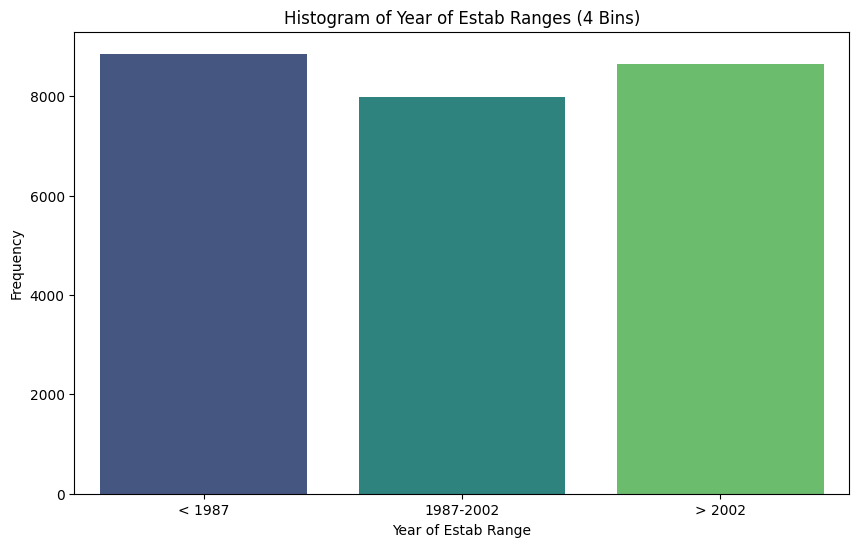

In [56]:
# Dividimos el número de empleados en rangos

# Define the bin edges
bins = [0, 1987, 2002, df['no_of_employees'].max() + 1] #al último bin se le suma 1 al máximo para que no quede fuera del bin el registro con el valor máximo
labels = ['< 1987', '1987-2002', '> 2002']

# Create a new column with the wage ranges
df['yr_of_estab_range'] = pd.cut(df['yr_of_estab'], bins=bins, labels=labels, right=False)

# Plot the histogram
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='yr_of_estab_range', order=labels, palette='viridis')
plt.title('Histogram of Year of Estab Ranges (4 Bins)')
plt.xlabel('Year of Estab Range')
plt.ylabel('Frequency')
plt.show()

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25480 entries, 0 to 25479
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   continent              25480 non-null  object  
 1   education_of_employee  25480 non-null  object  
 2   has_job_experience     25480 non-null  object  
 3   requires_job_training  25480 non-null  object  
 4   no_of_employees        25480 non-null  int64   
 5   yr_of_estab            25480 non-null  int64   
 6   region_of_employment   25480 non-null  object  
 7   unit_of_wage           25480 non-null  object  
 8   full_time_position     25480 non-null  object  
 9   case_status            25480 non-null  object  
 10  wage_range             25480 non-null  object  
 11  no_of_employees_range  25480 non-null  category
 12  yr_of_estab_range      25480 non-null  category
dtypes: category(2), int64(2), object(9)
memory usage: 2.2+ MB


In [58]:
# Convertimos las columnas de category a object

df['no_of_employees_range'] = df['no_of_employees_range'].astype('object')
df['yr_of_estab_range'] = df['yr_of_estab_range'].astype('object')
df.dtypes

,0
continent,object
education_of_employee,object
has_job_experience,object
requires_job_training,object
no_of_employees,int64
yr_of_estab,int64
region_of_employment,object
unit_of_wage,object
full_time_position,object
case_status,object


In [59]:
# Eliminamos las columnas numéricas 'no_of_employees' y 'yr_of_estab'

#df.drop(columns=['no_of_employees', 'yr_of_estab'], inplace=True)
#df.T

XtrainT = Xtrain.copy()
XvalT = Xval.copy()
XtestT =Xtest.copy()

XtrainT.drop(columns=['no_of_employees', 'yr_of_estab'], inplace=True)
XvalT.drop(columns=['no_of_employees', 'yr_of_estab'], inplace=True)
XtestT.drop(columns=['no_of_employees', 'yr_of_estab'], inplace=True)


##**Esta sección no aplica**

**a) Con base a estos gráficos ¿qué tipo de transformaciones sugieres llevar a cabo en dichas variables?**


Puesto que los gráficos muestran que algunas variables se encuentran sesgadas, se aplicará una transformación exponencial o quantile transformer (se hará la prueba con ambas) para procurar que tengan una distribución gaussiana.

Por otra parte, las escalas de todas las variables son muy diferentes entre sí, por lo cual se podría aplicar junto con la transformación exponencial, una estandarización, para que todas las variables se encuentren dentro del mismo rango. En el caso del quantile transformer, los valores quedan escalados aproximadamente al mismo rango para todas las variables.

Finalmente cabe destacar que para la variable **'Deductible'** <Mark>la mayoría de los valores son 400 y solamente hay unos cuantos valores de 300,500 y 700 por lo que probablemente también debería eliminarse del análisis</Mark>. Por el momento se dejará.

<br><br>
**i. Se aplican las transformaciones, evitando el
filtrado de información (data-leakage). Estas nuevas variables
transformadas se llamarán XtrainT, XvalT y XtestT.**

Para evitar el filtrado de información, se aplica el "fit" del conjunto de entrenamiento para transformar los conjuntos de entrenamiento, validación y prueba.

In [ ]:
"""
# Este código transforma los datos con Yeo-Johnson
pt = PowerTransformer().set_output(transform="pandas")
pt.fit(Xtrain[num_cols])
PowerTransformer(method='yeo-johnson', standardize=True)
XtrainT = pt.transform(Xtrain[num_cols])
XvalT = pt.transform(Xval[num_cols])
XtestT = pt.transform(Xtest[num_cols])
"""

In [ ]:
"""
fig, axes = plt.subplots(5,2, figsize=(30,60)) # ---> Matplotlib
plt.subplots_adjust(wspace=0.3)
axes = axes.ravel()
i = 0
for col, ax in zip(Xtrain[num_cols], axes):
  i = i + 1
  plt.subplot(5,2,i)
  plt.hist(Xtrain[col], bins=10)
  #sns.countplot(x = Xtrain[col], ax=ax)
  plt.ylabel(f'{col}')
  plt.xlabel("XTrain")
  i = i + 1
  plt.subplot(5,2,i)
  plt.hist(XtrainT[col], bins=10)
  #sns.countplot(x = XtrainT[col], ax=ax)
  plt.ylabel(f'{col}')
  plt.xlabel("XTrainT")
fig.subplots_adjust(hspace=.5)
"""

In [ ]:
"""
# Este código transforma los datos con Quantile Transformer
qt = QuantileTransformer(n_quantiles=10, output_distribution="normal", random_state=1).set_output(transform="pandas")
qt.fit(Xtrain[num_cols])
#PowerTransformer(method='yeo-johnson', standardize=True)
XtrainT = qt.transform(Xtrain[num_cols])
XvalT = qt.transform(Xval[num_cols])
XtestT = qt.transform(Xtest[num_cols])
"""

In [ ]:
"""
fig, axes = plt.subplots(5,2, figsize=(30,60)) # ---> Matplotlib
plt.subplots_adjust(wspace=0.3)
axes = axes.ravel()
i = 0
for col, ax in zip(Xtrain[num_cols], axes):
  i = i + 1
  plt.subplot(5,2,i)
  plt.hist(Xtrain[col], bins=10)
  plt.ylabel(f'{col}')
  plt.xlabel("XTrain")
  i = i + 1
  plt.subplot(5,2,i)
  plt.hist(XtrainT[col], bins=10)
  plt.ylabel(f'{col}')
  plt.xlabel("XTrainT")
fig.subplots_adjust(hspace=.5)
"""

Al comparar los histogrmas de las variables originales vs. las transformadas, podemos ver que en general se logra una distribución más gaussiana aplicando la transformación quantile transformer


Una vez que se han transformado las variables numéricas para que tengan una distribución gaussiana, se les aplicará una transformación min-max para que se encuentren en el rango de 0 a 1 al igual que las binarias y las nominales cuando se transformen posteriormente

In [ ]:
"""
# Este código transforma los datos con MinMaxScaler
scaler = MinMaxScaler().set_output(transform="pandas")
scaler.fit(XtrainT[num_cols])

XtrainT = scaler.transform(XtrainT[num_cols])
XvalT = scaler.transform(XvalT[num_cols])
XtestT = scaler.transform(XtestT[num_cols])
"""

In [ ]:
"""
fig, axes = plt.subplots(5,2, figsize=(30,60)) # ---> Matplotlib
plt.subplots_adjust(wspace=0.3)
axes = axes.ravel()
i = 0
for col, ax in zip(Xtrain[num_cols], axes):
  i = i + 1
  plt.subplot(5,2,i)
  plt.hist(Xtrain[col], bins=10)
  plt.ylabel(f'{col}')
  plt.xlabel("XTrain")
  i = i + 1
  plt.subplot(5,2,i)
  plt.hist(XtrainT[col], bins=10)
  plt.ylabel(f'{col}')
  plt.xlabel("XTrainT")
fig.subplots_adjust(hspace=.5)
"""

##**Transformación de variables binarias**

**5) Se aplica la transformación LabelEncoder() de sklearn a todas las variables binarias, evitando el filtrado de información.**

In [60]:
# Las variables binarias son 'has_job_experience',	'requires_job_training', 'full_time_position'	y la variable de salida 'case_status'

# Se crea un dataframe auxiliar para aplicarle el LabelEncoder

df_train_le = pd.concat([ytrain['case_status'], Xtrain['has_job_experience'], Xtrain['requires_job_training'], Xtrain['full_time_position']], axis=1)
df_val_le = pd.concat([yval['case_status'], Xval['has_job_experience'], Xval['requires_job_training'], Xval['full_time_position']], axis=1)
df_test_le = pd.concat([ytest['case_status'], Xtest['has_job_experience'], Xtest['requires_job_training'], Xtest['full_time_position']], axis=1)

display(df_train_le,df_val_le,df_test_le)

,case_status,has_job_experience,requires_job_training,full_time_position
9036,Certified,N,N,Y
21818,Certified,N,N,Y
18343,Certified,Y,Y,Y
12820,Certified,N,Y,Y
21719,Denied,Y,N,Y
...,...,...,...,...
20737,Denied,Y,N,Y
20965,Denied,N,N,Y
2473,Certified,N,N,Y
743,Certified,Y,Y,Y


,case_status,has_job_experience,requires_job_training,full_time_position
18754,Denied,N,N,Y
5834,Certified,Y,N,Y
6962,Denied,N,N,Y
19174,Certified,N,N,Y
21977,Certified,Y,N,Y
...,...,...,...,...
710,Certified,Y,N,Y
6839,Certified,Y,N,Y
20114,Denied,N,N,Y
6425,Certified,Y,N,Y


,case_status,has_job_experience,requires_job_training,full_time_position
755,Denied,Y,N,Y
22508,Denied,N,N,Y
483,Certified,Y,N,Y
1724,Denied,N,Y,Y
14084,Denied,N,N,Y
...,...,...,...,...
5572,Certified,Y,N,N
767,Certified,Y,N,Y
13433,Certified,Y,N,Y
15409,Certified,N,Y,Y


In [61]:
# Se definen los dataframes transformados para la variabe de salida 'case_status'
ytrainT = ytrain
yvalT = yval
ytestT = ytest

# Se tranforman las variables binarias en el dataframe auxiliar

le = LabelEncoder()
bin_cols = ['case_status', 'has_job_experience', 'requires_job_training', 'full_time_position']

for col in bin_cols:
  le.fit(df_train_le[col])
  LabelEncoder()
  if col == 'case_status':
    ytrainT[col] = le.transform(df_train_le[col])
    yvalT[col] = le.transform(df_val_le[col])
    ytestT[col] = le.transform(df_test_le[col])
  else:
    XtrainT[col] = le.transform(df_train_le[col])
    XvalT[col] = le.transform(df_val_le[col])
    XtestT[col] = le.transform(df_test_le[col])

# Se eliminan los dataframes auxiliares

del df_train_le
del df_val_le
del df_test_le

display(ytrainT, yvalT, ytestT, XtrainT, XvalT, XtestT)

,case_status
9036,0
21818,0
18343,0
12820,0
21719,1
...,...
20737,1
20965,1
2473,0
743,0


,case_status
18754,1
5834,0
6962,1
19174,0
21977,0
...,...
710,0
6839,0
20114,1
6425,0


,case_status
755,1
22508,1
483,0
1724,1
14084,1
...,...
5572,0
767,0
13433,0
15409,0


,continent,education_of_employee,has_job_experience,requires_job_training,region_of_employment,unit_of_wage,full_time_position,wage_range
9036,Africa,Bachelor's,0,0,Northeast,Hour,1,> 100000
21818,Asia,Bachelor's,0,0,Northeast,Year,1,< 50000
18343,Europe,Doctorate,1,1,West,Year,1,> 100000
12820,Asia,Bachelor's,0,1,West,Year,1,50000-100000
21719,Asia,Bachelor's,1,0,South,Year,1,50000-100000
...,...,...,...,...,...,...,...,...
20737,Asia,Bachelor's,1,0,Northeast,Hour,1,50000-100000
20965,Asia,Master's,0,0,South,Year,1,50000-100000
2473,Europe,Bachelor's,0,0,West,Hour,1,> 100000
743,Europe,Bachelor's,1,1,South,Year,1,50000-100000


,continent,education_of_employee,has_job_experience,requires_job_training,region_of_employment,unit_of_wage,full_time_position,wage_range
18754,Asia,Bachelor's,0,0,Northeast,Year,1,50000-100000
5834,Asia,Doctorate,1,0,South,Year,1,> 100000
6962,Europe,Master's,0,0,West,Year,1,50000-100000
19174,Asia,Bachelor's,0,0,Midwest,Year,1,50000-100000
21977,Asia,Master's,1,0,Midwest,Year,1,50000-100000
...,...,...,...,...,...,...,...,...
710,Europe,Bachelor's,1,0,West,Year,1,< 50000
6839,North America,Bachelor's,1,0,Northeast,Year,1,> 100000
20114,Europe,High School,0,0,Midwest,Year,1,> 100000
6425,Europe,Bachelor's,1,0,Northeast,Year,1,< 50000


,continent,education_of_employee,has_job_experience,requires_job_training,region_of_employment,unit_of_wage,full_time_position,wage_range
755,Asia,High School,1,0,Northeast,Year,1,< 50000
22508,Asia,Bachelor's,0,0,South,Year,1,> 100000
483,North America,Doctorate,1,0,Northeast,Year,1,< 50000
1724,Asia,Bachelor's,0,1,Northeast,Year,1,< 50000
14084,Asia,Master's,0,0,Northeast,Hour,1,< 50000
...,...,...,...,...,...,...,...,...
5572,Asia,Master's,1,0,Northeast,Year,0,50000-100000
767,Asia,Bachelor's,1,0,West,Year,1,< 50000
13433,Asia,Master's,1,0,South,Year,1,50000-100000
15409,Asia,Doctorate,0,1,West,Year,1,> 100000


**a) En particular, se obtine la distribución de las clases de la variable de salida "case_status". Con base a dicha distribución, ¿se puede considerar que existe un problema de datos no balanceados?**

<Axes: xlabel='case_status', ylabel='count'>

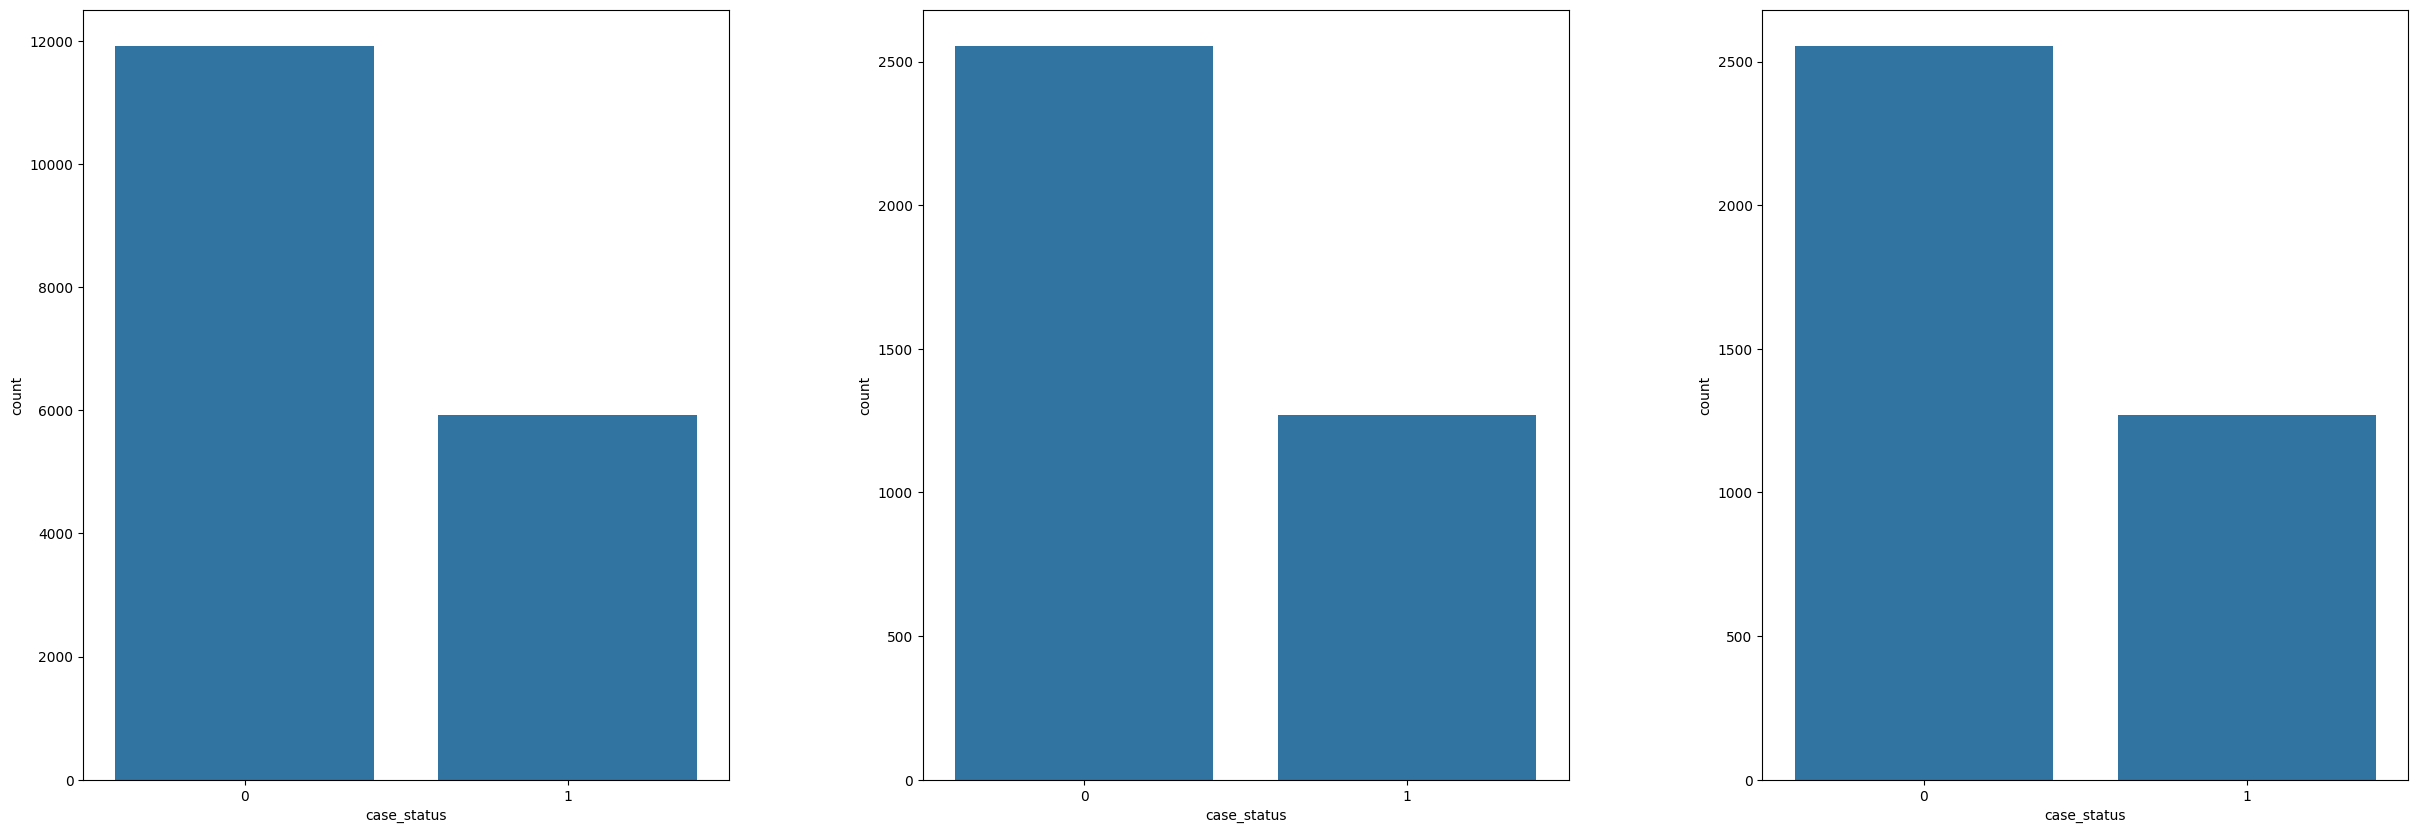

In [62]:
fig, axes = plt.subplots(1,3, figsize=(30,10)) # ---> Matplotlib
plt.subplots_adjust(wspace=0.3)
axes = axes.ravel()

plt.subplot(1,3,1)
sns.countplot(ytrainT, x='case_status')

plt.subplot(1,3,2)
sns.countplot(yvalT, x='case_status')

plt.subplot(1,3,3)
sns.countplot(ytestT, x='case_status')


<br><br>
En la gráfica se puede apreciar que los casos de aprobación de visa son aproximadamente el doble que los casos de rechazo. Aunque la distribución es mayor para los casos de aprobación, la proporción no es tan grande como para considerar que existe un problema de datos no balanceados, auqneu debemos tomar en cuenta esta proporción a la hora de analizar las métricas de desempeño del modelo
<br><br>

**6) Se realiza una inspección de las variables ordinales para determinar qué transformaciones aplicarles.**

La variables ordinales son: 'education_of_employee' y 'wage_range'
<br><br>
Se graficará el boxplot de estas variables para observar si hay valores atípicos
<br><br>
Se les aplicará la transformación OrdinalEncoder para definir sus respectivas categorías con los valores de 0, 1, 2, etc. según corresponda.
<br><br>
Posteriormente se les aplicará la transformación QuantileTransformer para que tengan un rango similar entre ellas.

In [63]:
!pip show seaborn

Name: seaborn
Version: 0.13.2
Summary: Statistical data visualization
Home-page: 
Author: 
Author-email: Michael Waskom <mwaskom@gmail.com>
License: 
Location: /usr/local/lib/python3.11/dist-packages
Requires: matplotlib, numpy, pandas
Required-by: missingno


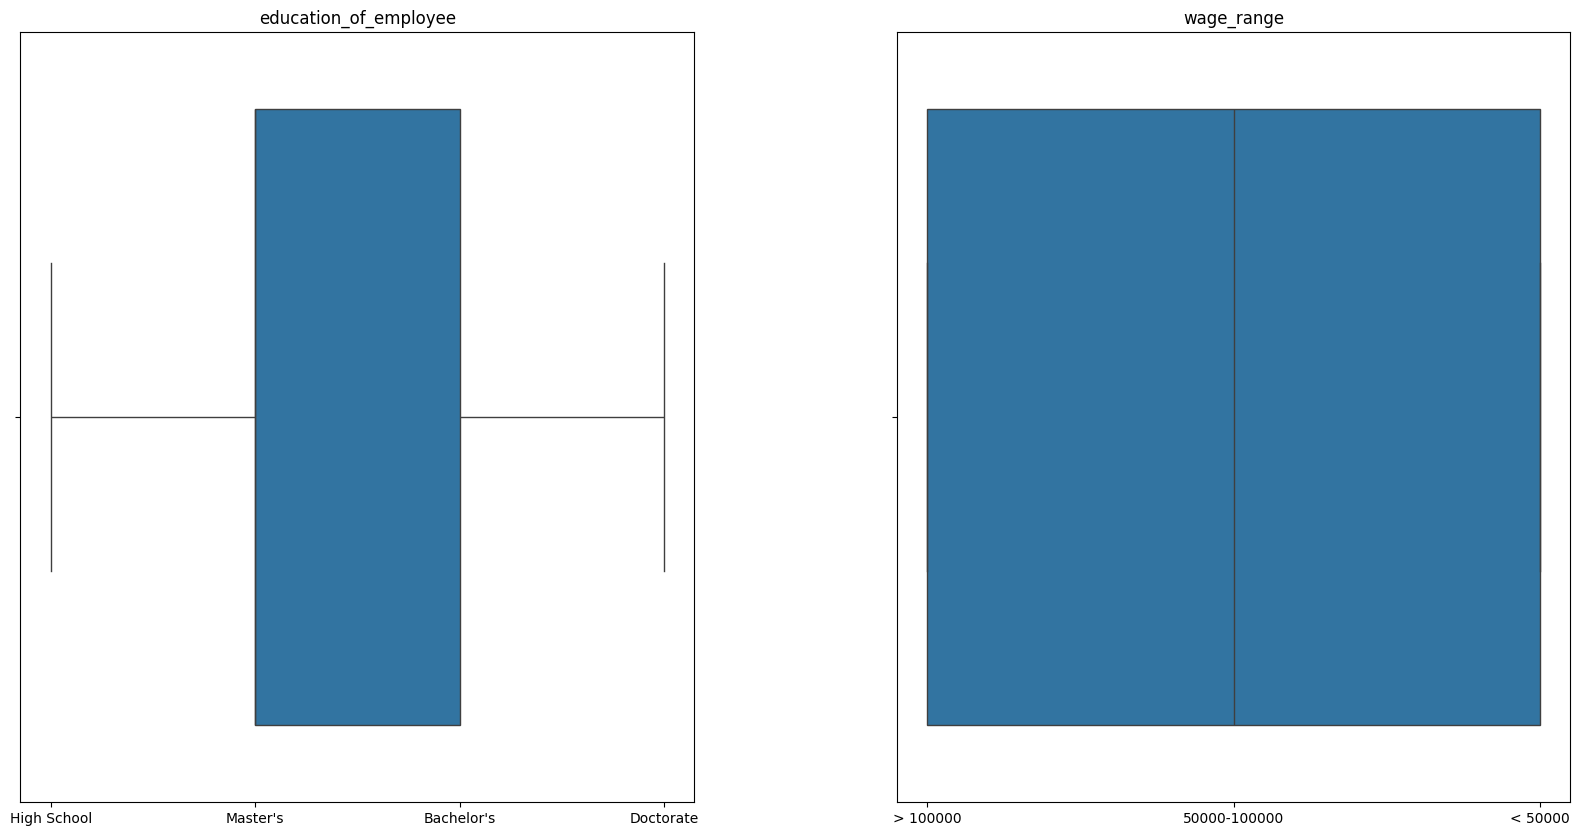

In [64]:
#se definen la variables de entrada ordinales
ord_col = ['education_of_employee','wage_range']

fig, axes = plt.subplots(1,2, figsize=(20,10)) # ---> Matplotlib
plt.subplots_adjust(wspace=0.3)
axes = axes.ravel()
for col, ax in zip(Xtrain[ord_col], axes):
  sns.boxplot(x=df[col], ax=ax) # ---> Seaborn
  ax.set(title=f'{col}', xlabel=None) # ---> Matplotlib
fig.subplots_adjust(hspace=.5)

In [65]:
cats_01 = ["High School", "Bachelor's", "Master's", "Doctorate"]
cats_02 = ['< 50000', '50000-100000', '> 100000']



categories = [cats_01, cats_02]

oe = OrdinalEncoder(categories=categories, dtype=int)

#se definen la variables de entrada ordinales
ord_col = ['education_of_employee','wage_range']

# Se definen los dataframes transformados con OrdinalEncoder
XtrainT_OE = pd.DataFrame()
XvalT_OE = pd.DataFrame()
XtestT_OE = pd.DataFrame()

# Se les asigna el valor sin transfrormar para que no estén vacios y no arroje error el oe.transform
XtrainT_OE[ord_col] = Xtrain[ord_col]
XvalT_OE[ord_col] = Xval[ord_col]
XtestT_OE[ord_col] = Xtest[ord_col]

# Se aplica la transformación OrdinalEncoder
oe.fit(Xtrain[ord_col])
OrdinalEncoder()
XtrainT_OE[ord_col] = oe.transform(Xtrain[ord_col])
XvalT_OE[ord_col] = oe.transform(Xval[ord_col])
XtestT_OE[ord_col] = oe.transform(Xtest[ord_col])



In [66]:
display(Xtrain[ord_col].head(), Xval[ord_col].head(), Xtest[ord_col].head(), XtrainT_OE.head(), XvalT_OE.head(), XtestT_OE.head())

,education_of_employee,wage_range
9036,Bachelor's,> 100000
21818,Bachelor's,< 50000
18343,Doctorate,> 100000
12820,Bachelor's,50000-100000
21719,Bachelor's,50000-100000


,education_of_employee,wage_range
18754,Bachelor's,50000-100000
5834,Doctorate,> 100000
6962,Master's,50000-100000
19174,Bachelor's,50000-100000
21977,Master's,50000-100000


,education_of_employee,wage_range
755,High School,< 50000
22508,Bachelor's,> 100000
483,Doctorate,< 50000
1724,Bachelor's,< 50000
14084,Master's,< 50000


,education_of_employee,wage_range
9036,1,2
21818,1,0
18343,3,2
12820,1,1
21719,1,1


,education_of_employee,wage_range
18754,1,1
5834,3,2
6962,2,1
19174,1,1
21977,2,1


,education_of_employee,wage_range
755,0,0
22508,1,2
483,3,0
1724,1,0
14084,2,0


In [67]:
# Este código transforma los datos con Quantile Transformer
qt = QuantileTransformer(n_quantiles=10, output_distribution="normal", random_state=1).set_output(transform="pandas")
qt.fit(XtrainT_OE[ord_col])

XtrainT[ord_col] = qt.transform(XtrainT_OE[ord_col])
XvalT[ord_col] = qt.transform(XvalT_OE[ord_col])
XtestT[ord_col] = qt.transform(XtestT_OE[ord_col])

In [68]:
# Este código transforma los datos con MinMaxScaler
scaler = MinMaxScaler().set_output(transform="pandas")
scaler.fit(XtrainT[ord_col])

XtrainT[ord_col] = scaler.transform(XtrainT[ord_col])
XvalT[ord_col] = scaler.transform(XvalT[ord_col])
XtestT[ord_col] = scaler.transform(XtestT[ord_col])

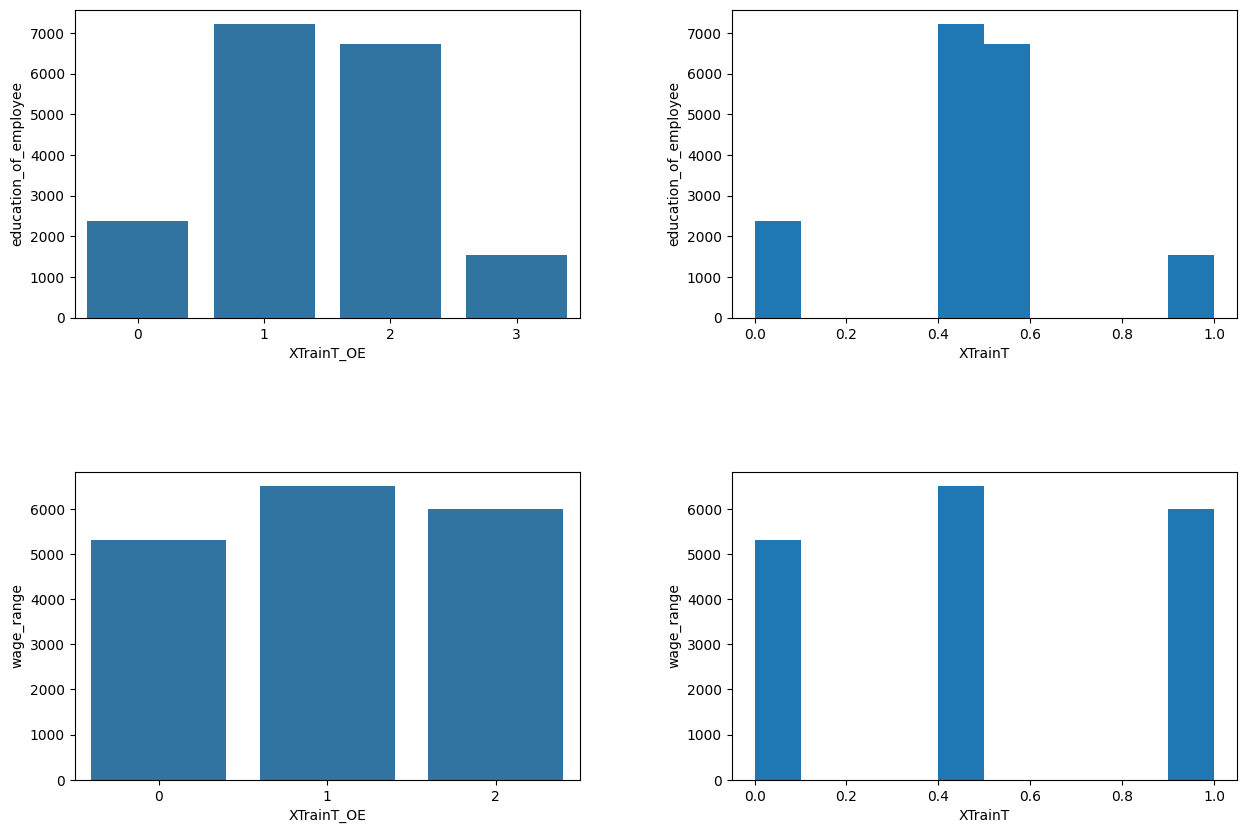

In [69]:
#Se comparan los datos del ordinal encoder original vs. los transformados con MinMaxScaler

fig, axes = plt.subplots(2,2, figsize=(15,10)) # ---> Matplotlib
plt.subplots_adjust(wspace=0.3)
axes = axes.ravel()

i = 0
for col, ax in zip(XtrainT_OE[ord_col], axes):

  i = i + 1
  plt.subplot(2,2,i)
  sns.countplot(x=XtrainT_OE[col])
  plt.ylabel(f'{col}')
  plt.xlabel("XTrainT_OE")

  i = i + 1
  plt.subplot(2,2,i)
  plt.hist(XtrainT[col], bins=10)
  plt.ylabel(f'{col}')
  plt.xlabel("XTrainT")
fig.subplots_adjust(hspace=.5)




In [70]:
# Se eliminan los dataframe auxiliares

del XtrainT_OE
del XvalT_OE
del XtestT_OE


**7) Se obtiene la matriz de correlación de los factores obtenidos hasta el momento, incluyendo la variable “case_status”.**

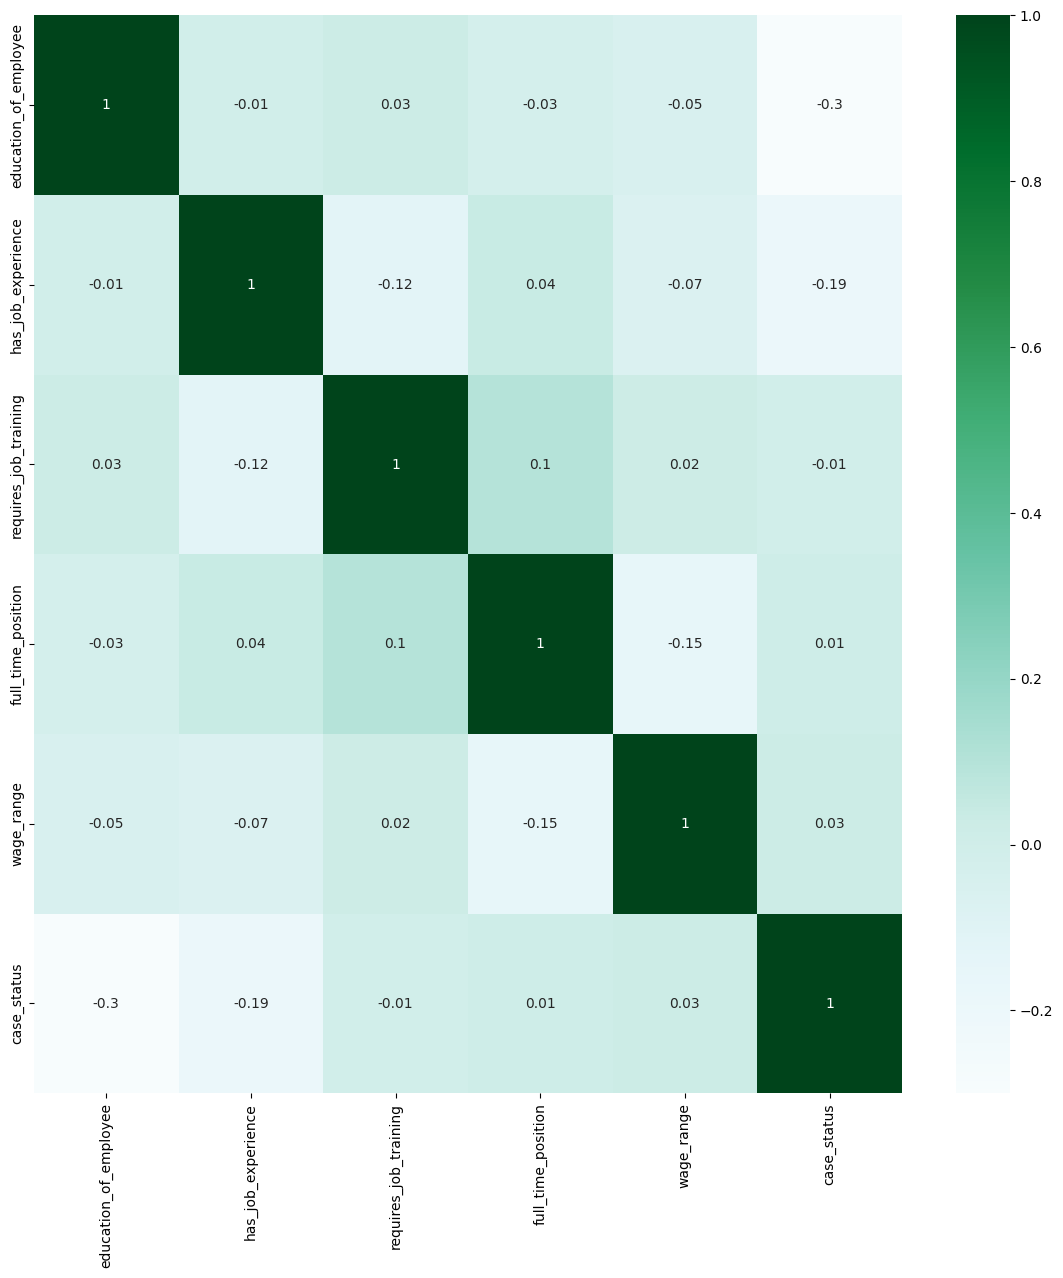

In [71]:
combined_df = pd.concat([XtrainT, ytrainT], axis=1)

fig, ax = plt.subplots(figsize=(14,14))
ax = sns.heatmap(round(combined_df.corr(method='pearson', numeric_only=True),2), annot=True, cmap="BuGn")
im = ax.collections[0]

**a) Correlaciones positivas “fuertes” entre pares de factores dentro de la matriz.**

Tomando en cuenta que  una correlación se considera "fuerte" cuando su coeficiente de Pearson es mayor o igual a 0.6 en estudios de personas.

No se observan correlaciones positivas fuertes entre variables independientes

Tampoco se observa ninguna correlación fuerte de alguna variable independiente con la variable 'case_status'.

**b) Correlaciones negativas “fuertes” entre pares de factores dentro de la matriz.**

Tampoco existen correlaciones negativas fuertes (con coeficiente de Pearson menor a -0.60) en la matriz de correlación obtenida, aunque cabe destacar que la correlación negatiiva más fuerte de una variable independiente con la variable 'case_status' es la de la variable 'has_job_experience', sugiriendo que es menos probable que se abruebe la visa de trabajo a personas que no tienen experiencia laboral.

**8) Se aplica la transformación get_dummies() de Pandas a las variables nominales, evitando el filtrado de información y usando el argumento “drop_first” para generar “k-1” variables “dummies”, de las “k” que cada variable.**

In [72]:
#se obtiene el listado de variables categóricas

cat_cols = df.select_dtypes(exclude=np.number).columns.tolist()
cat_cols

['continent',
 'education_of_employee',
 'has_job_experience',
 'requires_job_training',
 'region_of_employment',
 'unit_of_wage',
 'full_time_position',
 'case_status',
 'wage_range',
 'no_of_employees_range',
 'yr_of_estab_range']

In [73]:
# se remueven del listado las variables ordinales y binarias que ya se preprocesaron

nomi_cols = list(set(cat_cols) - set(bin_cols) - set(ord_col))

nomi_cols.sort()

nomi_cols

['continent',
 'no_of_employees_range',
 'region_of_employment',
 'unit_of_wage',
 'yr_of_estab_range']

In [74]:
# Se crea un dataframe con las variables nominales

df_nomi = df[nomi_cols]

df_nomi

,continent,no_of_employees_range,region_of_employment,unit_of_wage,yr_of_estab_range
0,Asia,> 3450,West,Hour,> 2002
1,Asia,2300-3450,Northeast,Year,> 2002
2,Asia,> 3450,West,Year,> 2002
3,Asia,< 1150,West,Year,< 1987
4,Africa,< 1150,South,Year,> 2002
...,...,...,...,...,...
25475,Asia,2300-3450,South,Year,> 2002
25476,Asia,2300-3450,Northeast,Year,> 2002
25477,Asia,< 1150,South,Year,< 1987
25478,Asia,1150-2300,West,Year,< 1987


In [75]:
# Se aplica la transformación get_dummies()

df_nomi_dummies = pd.get_dummies(df_nomi, drop_first=True, dtype='int')

df_nomi_dummies

,continent_Asia,continent_Europe,continent_North America,continent_Oceania,continent_South America,no_of_employees_range_2300-3450,no_of_employees_range_< 1150,no_of_employees_range_> 3450,region_of_employment_Midwest,region_of_employment_Northeast,region_of_employment_South,region_of_employment_West,unit_of_wage_Month,unit_of_wage_Week,unit_of_wage_Year,yr_of_estab_range_< 1987,yr_of_estab_range_> 2002
0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1
1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1
2,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1
3,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0
4,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25475,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1
25476,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1
25477,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0
25478,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0


In [76]:
# Se incorpora la variable 'case_status' al dataframe para que posteriormente se separe en los conjuntos de
# Entrenamiento, Validación y Prueba conservando la estratificación de esta variable

df_nomi_dummies['case_status'] = df['case_status']

df_nomi_dummies

,continent_Asia,continent_Europe,continent_North America,continent_Oceania,continent_South America,no_of_employees_range_2300-3450,no_of_employees_range_< 1150,no_of_employees_range_> 3450,region_of_employment_Midwest,region_of_employment_Northeast,region_of_employment_South,region_of_employment_West,unit_of_wage_Month,unit_of_wage_Week,unit_of_wage_Year,yr_of_estab_range_< 1987,yr_of_estab_range_> 2002,case_status
0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,Denied
1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,Certified
2,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,Denied
3,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0,Denied
4,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,Certified
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25475,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,Certified
25476,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,Certified
25477,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,Certified
25478,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,Certified


In [77]:
# Se divide el dataframe en los conjuntos Auxiliar y Prueba
strat_aux_set, strat_test_set = train_test_split(
df_nomi_dummies, test_size=0.15, stratify=df_nomi_dummies["case_status"], random_state=1)

# Se divide el conjunto Auxiliar en los conjuntos Entrenamiento y Validación
strat_train_set, strat_val_set = train_test_split(
strat_aux_set, test_size=0.17647, stratify=strat_aux_set["case_status"], random_state=1)



In [78]:
# Se despliegan los conjuntos obtenidos
display(strat_train_set,strat_val_set,strat_test_set)

,continent_Asia,continent_Europe,continent_North America,continent_Oceania,continent_South America,no_of_employees_range_2300-3450,no_of_employees_range_< 1150,no_of_employees_range_> 3450,region_of_employment_Midwest,region_of_employment_Northeast,region_of_employment_South,region_of_employment_West,unit_of_wage_Month,unit_of_wage_Week,unit_of_wage_Year,yr_of_estab_range_< 1987,yr_of_estab_range_> 2002,case_status
9036,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,Certified
21818,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,Certified
18343,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,Certified
12820,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,Certified
21719,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,Denied
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20737,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,Denied
20965,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,Denied
2473,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,Certified
743,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,Certified


,continent_Asia,continent_Europe,continent_North America,continent_Oceania,continent_South America,no_of_employees_range_2300-3450,no_of_employees_range_< 1150,no_of_employees_range_> 3450,region_of_employment_Midwest,region_of_employment_Northeast,region_of_employment_South,region_of_employment_West,unit_of_wage_Month,unit_of_wage_Week,unit_of_wage_Year,yr_of_estab_range_< 1987,yr_of_estab_range_> 2002,case_status
18754,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,Denied
5834,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,Certified
6962,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,Denied
19174,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,1,Certified
21977,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,Certified
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
710,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,Certified
6839,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,Certified
20114,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,Denied
6425,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,Certified


,continent_Asia,continent_Europe,continent_North America,continent_Oceania,continent_South America,no_of_employees_range_2300-3450,no_of_employees_range_< 1150,no_of_employees_range_> 3450,region_of_employment_Midwest,region_of_employment_Northeast,region_of_employment_South,region_of_employment_West,unit_of_wage_Month,unit_of_wage_Week,unit_of_wage_Year,yr_of_estab_range_< 1987,yr_of_estab_range_> 2002,case_status
755,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,Denied
22508,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,Denied
483,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1,Certified
1724,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,Denied
14084,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,Denied
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5572,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,Certified
767,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,Certified
13433,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,Certified
15409,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,Certified


In [79]:


# Se verifica que los conjuntos se hayan dividido en 70%, 15% y 15% conservando la proporción de datos (frecuencia) en la variabe 'case_status'

display(strat_train_set['case_status'].astype(object).describe(include = 'object'),strat_val_set['case_status'].astype(object).describe(include = 'object'),strat_test_set['case_status'].astype(object).describe(include = 'object'))




,case_status
count,17836
unique,2
top,Certified
freq,11912


,case_status
count,3822
unique,2
top,Certified
freq,2553


,case_status
count,3822
unique,2
top,Certified
freq,2553


In [80]:
# Se obtiene el listado de columnas excluyendo a la variable 'case_status'

dummy_cols_T = strat_train_set.columns.tolist()

dummy_cols_T = list(set(dummy_cols_T) - set(['case_status']))

dummy_cols_T.sort()

dummy_cols_T

['continent_Asia',
 'continent_Europe',
 'continent_North America',
 'continent_Oceania',
 'continent_South America',
 'no_of_employees_range_2300-3450',
 'no_of_employees_range_< 1150',
 'no_of_employees_range_> 3450',
 'region_of_employment_Midwest',
 'region_of_employment_Northeast',
 'region_of_employment_South',
 'region_of_employment_West',
 'unit_of_wage_Month',
 'unit_of_wage_Week',
 'unit_of_wage_Year',
 'yr_of_estab_range_< 1987',
 'yr_of_estab_range_> 2002']

In [81]:
# Se incorporan las variables transformadas a sus respectivos conjuntos de entrenamiento, validación y prueba

for col in dummy_cols_T:
  XtrainT[col] = strat_train_set[col]
  XvalT[col] = strat_val_set[col]
  XtestT[col] = strat_test_set[col]


In [82]:
# Se eliminan los dataframes auxiliares

del strat_train_set
del strat_val_set
del strat_test_set
del strat_aux_set
del df_nomi_dummies
del df_nomi

**9) Se usa la instrucción XtrainT.head().T, para desplegar los primeros registros de los datos de entrenamiento con todas las transformaciones realizadas hasta ahora.
NOTA: Hasta aquí los nombres de las variables siguen siendo los mismos: XtrainT,XvalT, XtestT, ytrainT, yvalT, ytestT.**

In [84]:
XtrainT.head()

,continent,education_of_employee,has_job_experience,requires_job_training,region_of_employment,unit_of_wage,full_time_position,wage_range,continent_Asia,continent_Europe,continent_North America,continent_Oceania,continent_South America,no_of_employees_range_2300-3450,no_of_employees_range_< 1150,no_of_employees_range_> 3450,region_of_employment_Midwest,region_of_employment_Northeast,region_of_employment_South,region_of_employment_West,unit_of_wage_Month,unit_of_wage_Week,unit_of_wage_Year,yr_of_estab_range_< 1987,yr_of_estab_range_> 2002
9036,Africa,0.458579,0,0,Northeast,Hour,1,1.000000,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
21818,Asia,0.458579,0,0,Northeast,Year,1,0.000000,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
18343,Europe,1.000000,1,1,West,Year,1,1.000000,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1
12820,Asia,0.458579,0,1,West,Year,1,0.486565,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1
21719,Asia,0.458579,1,0,South,Year,1,0.486565,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1


In [85]:
# Eliminamos de XtrainT, XvalT y XtestT las columnas ['continent','region_of_employment','unit_of_wage']

cols_to_remove = ['continent','region_of_employment','unit_of_wage']

XtrainT.drop(columns=cols_to_remove, inplace=True)
XvalT.drop(columns=cols_to_remove, inplace=True)
XtestT.drop(columns=cols_to_remove, inplace=True)

In [86]:
# Checamos como quedaron los dataframes

display(XtrainT.head(), XvalT.head(), XtestT.head())

,education_of_employee,has_job_experience,requires_job_training,full_time_position,wage_range,continent_Asia,continent_Europe,continent_North America,continent_Oceania,continent_South America,no_of_employees_range_2300-3450,no_of_employees_range_< 1150,no_of_employees_range_> 3450,region_of_employment_Midwest,region_of_employment_Northeast,region_of_employment_South,region_of_employment_West,unit_of_wage_Month,unit_of_wage_Week,unit_of_wage_Year,yr_of_estab_range_< 1987,yr_of_estab_range_> 2002
9036,0.458579,0,0,1,1.000000,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
21818,0.458579,0,0,1,0.000000,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
18343,1.000000,1,1,1,1.000000,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1
12820,0.458579,0,1,1,0.486565,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1
21719,0.458579,1,0,1,0.486565,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1


,education_of_employee,has_job_experience,requires_job_training,full_time_position,wage_range,continent_Asia,continent_Europe,continent_North America,continent_Oceania,continent_South America,no_of_employees_range_2300-3450,no_of_employees_range_< 1150,no_of_employees_range_> 3450,region_of_employment_Midwest,region_of_employment_Northeast,region_of_employment_South,region_of_employment_West,unit_of_wage_Month,unit_of_wage_Week,unit_of_wage_Year,yr_of_estab_range_< 1987,yr_of_estab_range_> 2002
18754,0.458579,0,0,1,0.486565,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1
5834,1.000000,1,0,1,1.000000,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0
6962,0.556686,0,0,1,0.486565,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0
19174,0.458579,0,0,1,0.486565,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,1
21977,0.556686,1,0,1,0.486565,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0


,education_of_employee,has_job_experience,requires_job_training,full_time_position,wage_range,continent_Asia,continent_Europe,continent_North America,continent_Oceania,continent_South America,no_of_employees_range_2300-3450,no_of_employees_range_< 1150,no_of_employees_range_> 3450,region_of_employment_Midwest,region_of_employment_Northeast,region_of_employment_South,region_of_employment_West,unit_of_wage_Month,unit_of_wage_Week,unit_of_wage_Year,yr_of_estab_range_< 1987,yr_of_estab_range_> 2002
755,0.000000,1,0,1,0.0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
22508,0.458579,0,0,1,1.0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
483,1.000000,1,0,1,0.0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1
1724,0.458579,0,1,1,0.0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0
14084,0.556686,0,0,1,0.0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1


**a) Despliega las dimensiones de los conjuntos XtrainT, XvalT y XtestT.**

In [100]:
print("La dimensión de XtrainT es " + str(XtrainT.shape))
print("La dimensión de XvalT es " + str(XvalT.shape))
print("La dimensión de XtestT es " + str(XtestT.shape))

La dimensión de XtrainT es (17836, 22)
La dimensión de XvalT es (3822, 22)
La dimensión de XtestT es (3822, 22)


#**PARTE 2: Análisis exploratorio entre factores**
<br>


**10) Se pueden analizar una buena cantidad de factores para buscar relaciones entre los
factores y la variable de salida “case_status”. A manera de
ejemplos, veamos solo algunas de dichas relaciones gráficamente y que pueden aportar
información al problema que enfrentamos.**

In [88]:
# Se crea un dataframe con el conjunto de entrenamiento que incluya la variable 'FraudFound_P' para comparar los gráficos
# de este conjunto con los gráficos del conjunto original y corroborar que se mantenga la misma proporción (en las variables que sea posible la comparación)

df_train_T = XtrainT.copy()
df_train_T['case_status'] = ytrainT['case_status']
df_train_T

,education_of_employee,has_job_experience,requires_job_training,full_time_position,wage_range,continent_Asia,continent_Europe,continent_North America,continent_Oceania,continent_South America,no_of_employees_range_2300-3450,no_of_employees_range_< 1150,no_of_employees_range_> 3450,region_of_employment_Midwest,region_of_employment_Northeast,region_of_employment_South,region_of_employment_West,unit_of_wage_Month,unit_of_wage_Week,unit_of_wage_Year,yr_of_estab_range_< 1987,yr_of_estab_range_> 2002,case_status
9036,0.458579,0,0,1,1.000000,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
21818,0.458579,0,0,1,0.000000,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
18343,1.000000,1,1,1,1.000000,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0
12820,0.458579,0,1,1,0.486565,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0
21719,0.458579,1,0,1,0.486565,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20737,0.458579,1,0,1,0.486565,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1
20965,0.556686,0,0,1,0.486565,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1
2473,0.458579,0,0,1,1.000000,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0
743,0.458579,1,1,1,0.486565,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0


**a) Las variables education_of_employee y "case_status".**

<Axes: xlabel='education_of_employee', ylabel='count'>

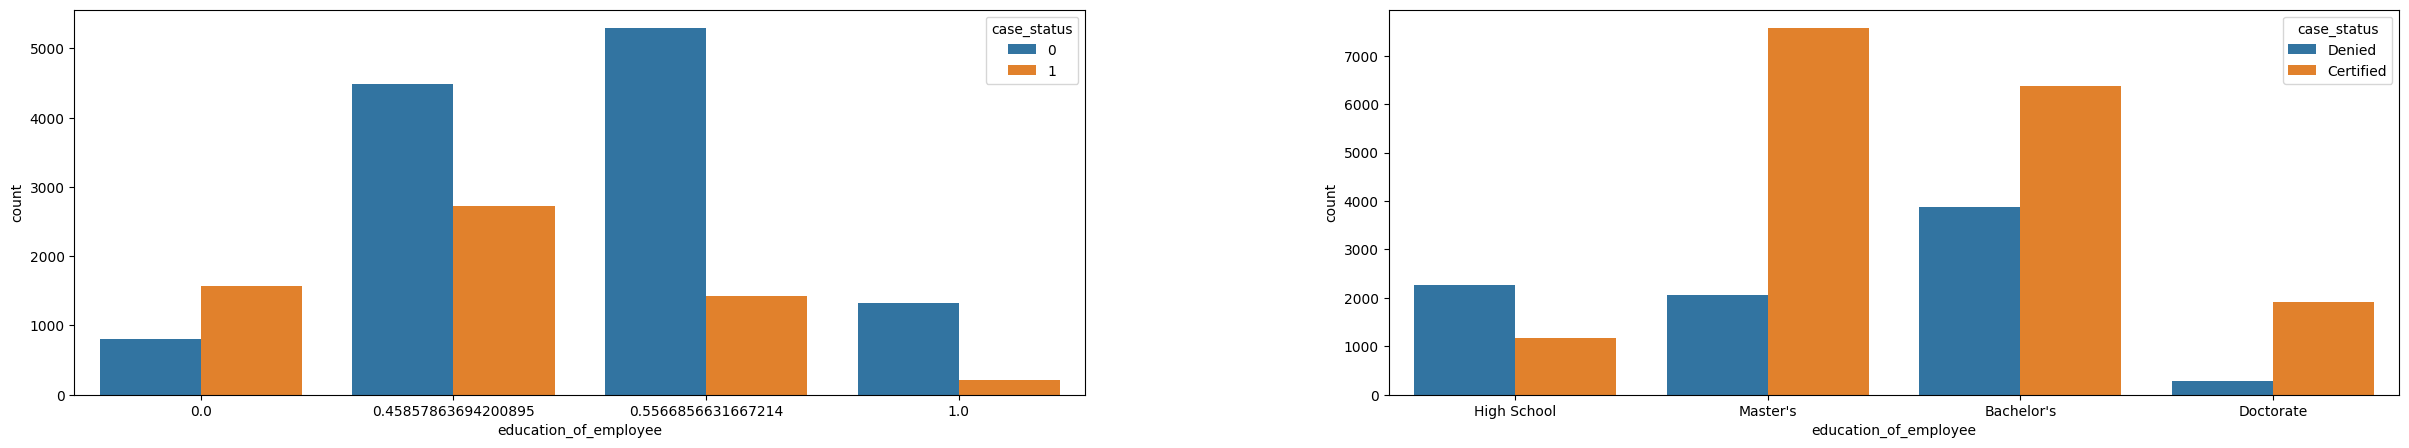

In [90]:
fig, axes = plt.subplots(1,2, figsize=(30,5)) # ---> Matplotlib
plt.subplots_adjust(wspace=0.3)
axes = axes.ravel()

plt.subplot(1,2,1)
sns.countplot(df_train_T, x="education_of_employee", hue="case_status")

plt.subplot(1,2,2)
sns.countplot(df, x="education_of_employee", hue="case_status")

**b) Las variables continent y “case_status”.**

<Axes: xlabel='continent', ylabel='count'>

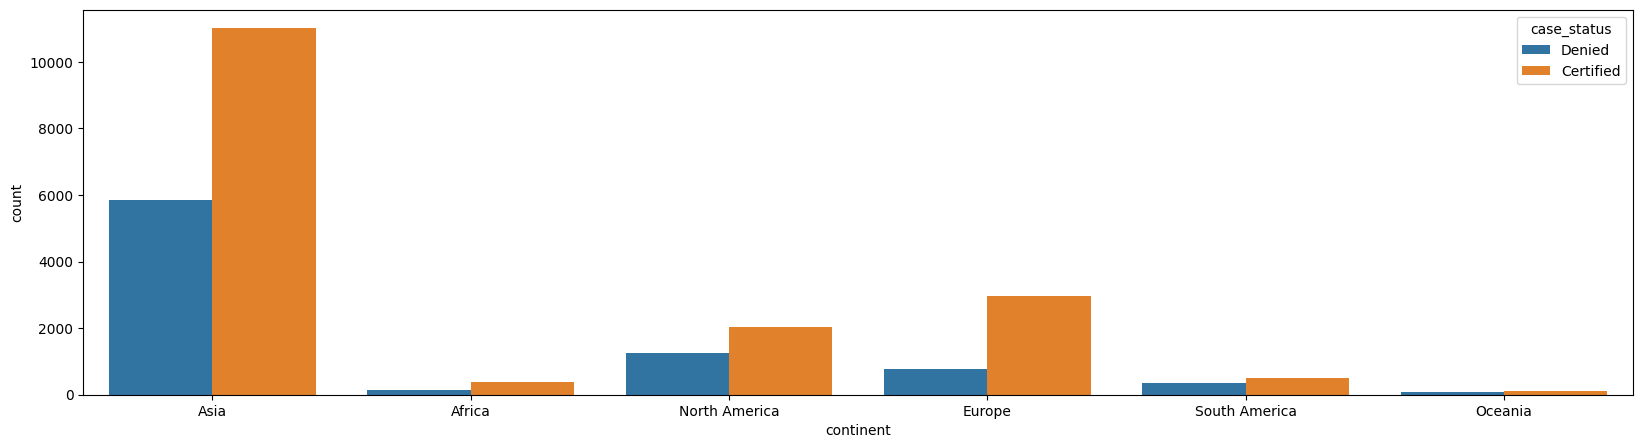

In [91]:
fig, axes = plt.subplots(1,1, figsize=(20,5)) # ---> Matplotlib
plt.subplots_adjust(wspace=0.3)

plt.subplot(1,1,1)
sns.countplot(df, x="continent", hue="case_status")

**c) Las variables has_job_experience y case_status.**


<Axes: xlabel='has_job_experience', ylabel='count'>

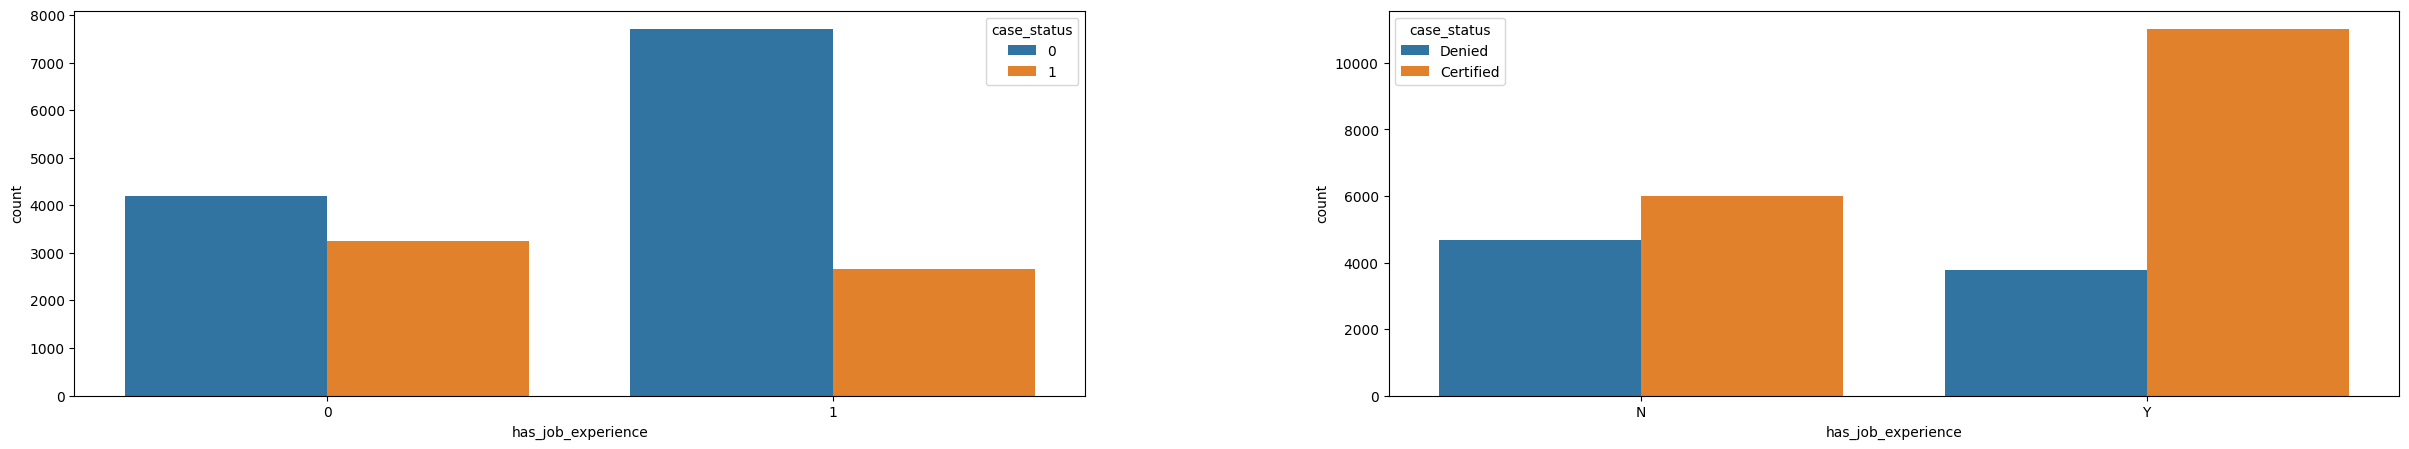

In [92]:
fig, axes = plt.subplots(1,2, figsize=(30,5)) # ---> Matplotlib
plt.subplots_adjust(wspace=0.3)
axes = axes.ravel()

plt.subplot(1,2,1)
sns.countplot(df_train_T, x="has_job_experience", hue="case_status")

plt.subplot(1,2,2)
sns.countplot(df, x="has_job_experience", hue="case_status")

**d) Incluye alguna otra relación o relaciones que consideres relevantes.**

<Axes: xlabel='unit_of_wage', ylabel='count'>

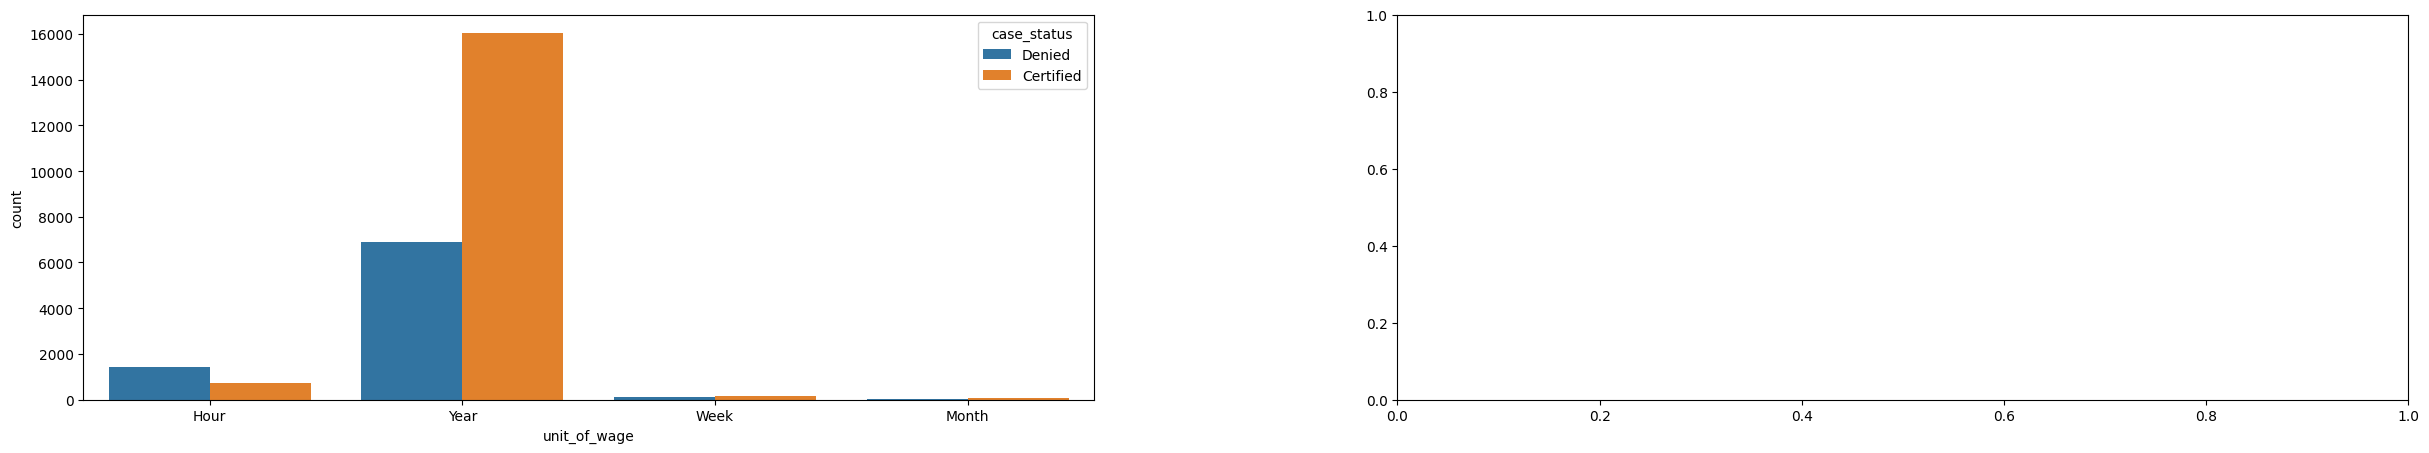

In [97]:
fig, axes = plt.subplots(1,2, figsize=(30,5)) # ---> Matplotlib
plt.subplots_adjust(wspace=0.3)
axes = axes.ravel()

plt.subplot(1,2,1)
sns.countplot(df, x="unit_of_wage", hue="case_status")

#plt.subplot(1,2,2)
#sns.countplot(df_train_T, x="unit_of_wage", hue="case_status")



<Axes: xlabel='full_time_position', ylabel='count'>

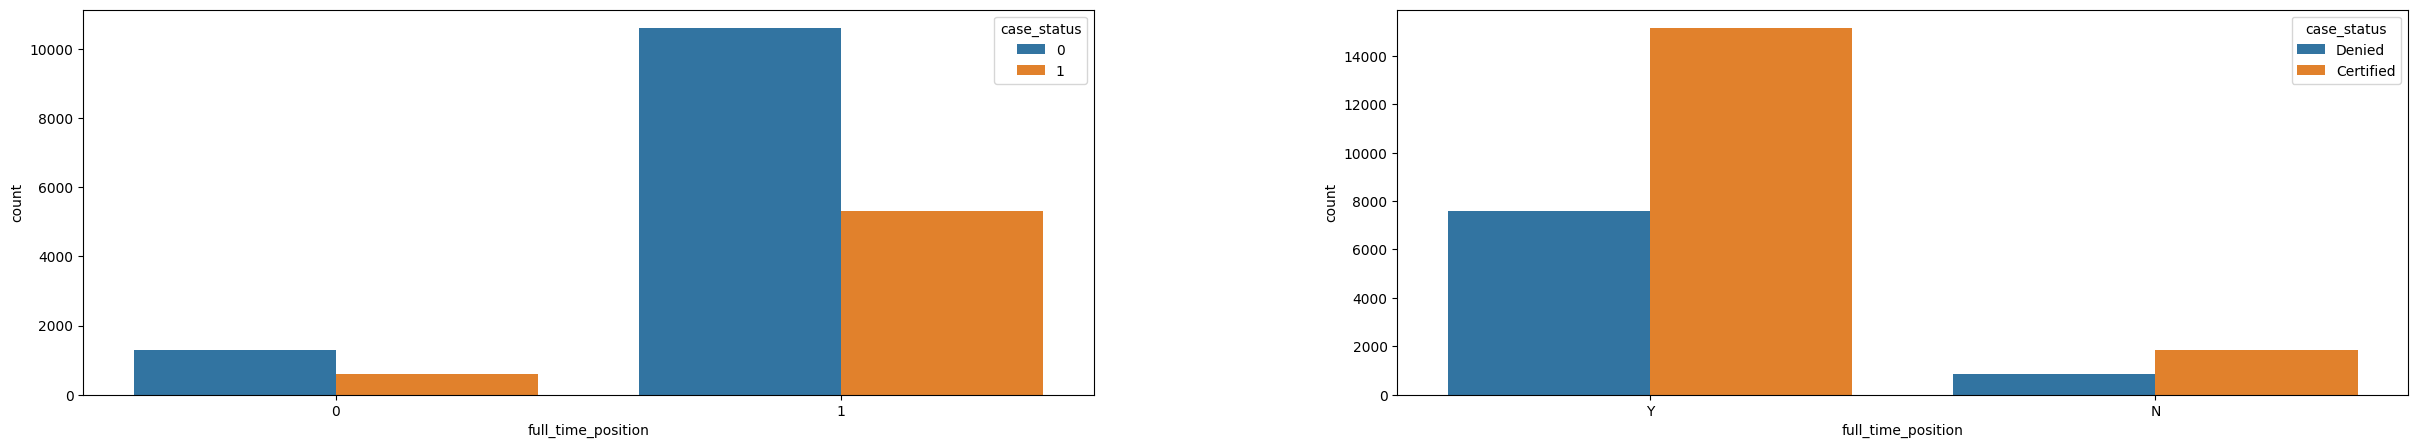

In [98]:
fig, axes = plt.subplots(1,2, figsize=(30,5)) # ---> Matplotlib
plt.subplots_adjust(wspace=0.3)
axes = axes.ravel()

plt.subplot(1,2,1)
sns.countplot(df_train_T, x="full_time_position", hue="case_status")

plt.subplot(1,2,2)
sns.countplot(df, x="full_time_position", hue="case_status")

<Axes: xlabel='requires_job_training', ylabel='count'>

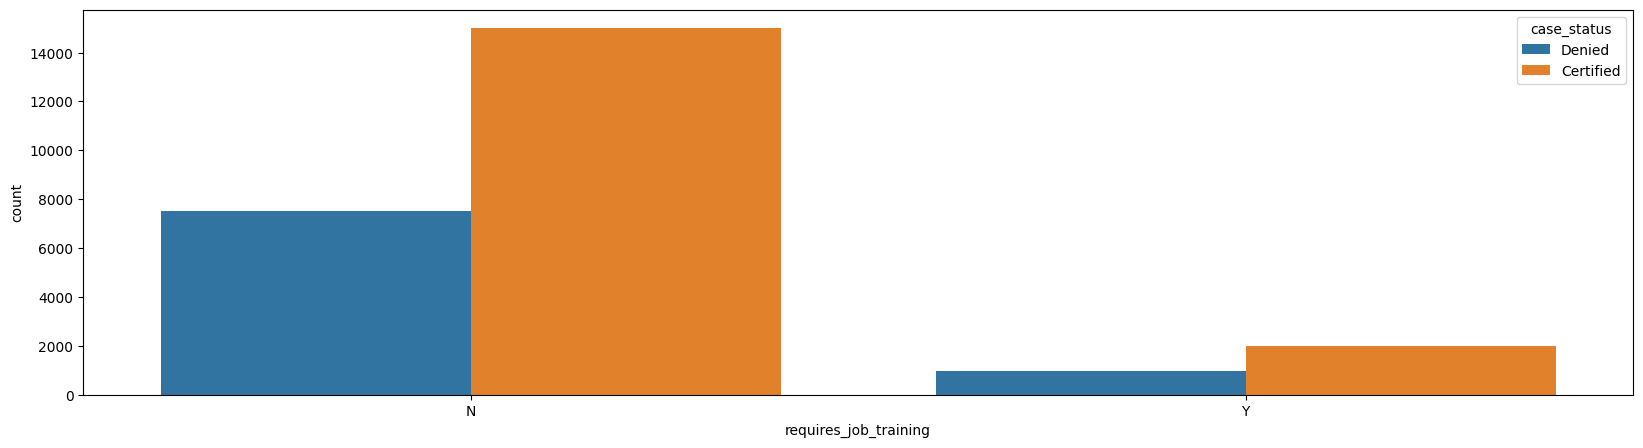

In [99]:
fig, axes = plt.subplots(1,1, figsize=(20,5)) # ---> Matplotlib
plt.subplots_adjust(wspace=0.3)

plt.subplot(1,1,1)
sns.countplot(df, x="requires_job_training", hue="case_status")

**e) Con base a los gráficos obtenidos incluye tus conclusiones al respecto.**

### Conclusión

Del primer gráfico podemos ver que los aplicantes que solamente tienen "Highschool" tienen menor probabilidad de aceptación de visa ya que los casos de rechazo son aproximadamente el doble que los casos de aceptación. Sin embargo, para los que tienen "Bachelor's" los casos de rechazo son cerca de dos terceras partes de los casos de aceptación. Para los que tienen "Master's" los casos de rechazo son aproximadamente una cuarta parte de los casos de aceptación y para los que tienen "Doctorate" los casos de rechazo son aproximadamente una sexta parte de los caosos de aceptación
<br><br>
Del segundo gráfico podemos ver para los aplicantes de Asia los casos de rechazo son aproximadamente la mitad de los casos de aceptación, pero para los aplicantes de Europa los casos de rechazo son aproximadamente una tercera parte de los casos de aceptación. Para los aplicantes de América del Norte los casos de rechazo son aproximadamente dos terceras partes de los casos de aceptación.
<br><br>
Del tercer gráfico podemos ver que para los aplicantes sin experiencia laboral los casos de rechazo son aproximadamente 3/4 partes de los casos de aceptación mientras que para los que sí tienen experiencia laboral los casos de rechazo son aproximadamente 1/3 parte de los casos de aceptación
<br><br>
Del cuarto gráfico podemos ver que para los aplicantes que tienen estipulado  un salario por hora los casos de rechazo son aproximadamente el doble de los casos de aceptación, mientras que para los palicantes que tienen estipulado un salario anual los casos de rechazo son menos de la mitad de los casos de aceptación.
<br><br>
Del quinto gráfico podemos ver que tanto para los aplicantes que no tienen una posición de tiempo completo como para los que sí la tienen, los casos de rechazo son aproximadamente la mitad de los casos de aceptación.
<br><br>
Finalmente, del sexto gráfico podemos ver que tanto para los aplicantes que no requieren entrenamiento laboral como para los que sí lo requieren, los casos de rechazo son aproximadamente la mitad de los casos de aceptación.

#**Se exportan los dataframes para continuar con la Ingeniería de Características**

In [105]:
#Se guardan los dataframes que se requerirán para ka Ingeniería de Características en archivos Pickle

import pickle
import os

df_list = [df, XtrainT, XvalT, XtestT, ytrainT, yvalT, ytestT]

df_names = ['df','XtrainT','XvalT', 'XtestT', 'ytrainT', 'yvalT', 'ytestT']

path = "/content/Dataset_VPAI/"

# Create the directory if it does not exist
os.makedirs(path, exist_ok=True)

for df_item in range(len(df_list)):
  with open(path + df_names[df_item] + '.pkl', 'wb') as f:
    pickle.dump(df_list[df_item], f)

In [108]:
#Se almacenan los archivos Pickle en un ZIP para descargarlo

import zipfile
import os

def zip_files(file_names, zip_file_name):
  """
  Zips the files specified in file_names into a zip archive.

  Args:
    file_names: A list of file names to be zipped.
    zip_file_name: The name of the zip archive to create.
  """

  # Extract the directory path from the zip file name
  zip_dir = os.path.dirname(zip_file_name)
  # Create the directory if it does not exist
  os.makedirs(zip_dir, exist_ok=True)

  with zipfile.ZipFile(zip_file_name, 'w') as zipf:
    for file_name in file_names:
      if os.path.exists(file_name):
        zipf.write(file_name)
      else:
        print(f"Warning: File '{file_name}' not found. Skipping.")

zip_files([f"/content/Dataset_VPAI/{name}.pkl" for name in df_names], '/content/Dataset_VPAI/my_data.zip')